In [1]:
import pandas as pd 
import numpy as np
from snowflake.snowpark import Session
import snowflake.snowpark.functions as sfunc
import snowflake.snowpark.types as stypes
import plotly.graph_objects as go
import plotly.express as px
from IPython.display import Image as IPImage
import statsmodels.formula.api as smf

from config import SNOWFLAKE_USER, SNOWFLAKE_PASSWORD

In [2]:
connection_parameters = {
    "user": SNOWFLAKE_USER,
    "password": SNOWFLAKE_PASSWORD,
    "account": "pca67849",
    "warehouse": "WH_4_XS",
    "database": "TEMPORARY_DATA",
    "schema": "MBONE",
}
    
session = Session.builder.configs(connection_parameters).create()

expert_skills = [
    "ChatGPT", "Expert System", "IBM Watson", "IPSoft Amelia", "Ithink", "Virtual Agents", 
    # added
    "Generative Artificial Intelligence",
    "Large Language Models",
]
auto_drive_skills = ["Autonomous Systems", "Lidar", "OpenCV", "Path Planning", "Remote Sensing"]
nlp_skills = [
    "ANTLR", "Automatic Speech Recognition (ASR)", "Chatbot", "Computational Linguistics", 
    "Distinguo", "Latent Dirichlet Allocation", "Latent Semantic Analysis", "Lexalytics", 
    "Lexical Acquisition", "Lexical Semantics", "Machine Translation (MT)", 
    "Modular Audio Recognition Framework (MARF)", "MoSes", "Natural Language Processing", 
    "Natural Language Toolkit (NLTK)", "Nearest Neighbour Algorithm", "OpenNLP", 
    "Sentiment Analysis/Opinion Mining", "Speech Recognition", "Text Mining", 
    "Text to Speech (TTS)", "Tokenization", "Word2Vec"
]
neural_network_skills = [
    "Caffe Deep Learning Framework", "Convolutional Neural Network (CNN)", "Deep Learning",
    "Deeplearning4j", "Keras", "Long Short-Term Memory (LSTM)", "MXNet", "Neural Networks",
    "Pybrain", "Recurrent Neural Network (RNN)", "TensorFlow"
]
ml_skills = [
    "AdaBoost algorithm", "Boosting (Machine Learning)", "Chi Square Automatic Interaction Detection (CHAID)",
    "Classification Algorithms", "Clustering Algorithms", "Decision Trees", "Dimensionality Reduction", 
    "Google Cloud Machine Learning Platform", "Gradient boosting", "H2O (software)", "Libsvm", 
    "Machine Learning", "Madlib", "Mahout", "Microsoft Cognitive Toolkit", "MLPACK (C++ library)", 
    "Mlpy", "Random Forests", "Recommender Systems", "Scikit-learn", "Semi-Supervised Learning", 
    "Supervised Learning (Machine Learning)", "Support Vector Machines (SVM)", 
    "Semantic Driven Subtractive Clustering Method (SDSCM)", "Torch (Machine Learning)", 
    "Unsupervised Learning", "Vowpal", "Xgboost"
]
robotics_skills = [
    "Blue Prism", "Electromechanical Systems", "Motion Planning", "Motoman Robot Programming", 
    "Robot Framework", "Robotic Systems", "Robot Operating System (ROS)", "Robot Programming", 
    "Servo Drives/Motors", "Simultaneous Localization and Mapping (SLAM)"
]
vision_skills = [
    "Computer Vision", "Image Processing", "Image Recognition", "Machine Vision", "Object Recognition"
]
# removed the term "Artificial Intelligence" from the expert skills
all_ai_skills = expert_skills + auto_drive_skills + nlp_skills + neural_network_skills + ml_skills + robotics_skills + vision_skills + ["Artificial Intelligence"]

# Preparing Postings Data

In [3]:
us_posts_df = session.read.table("OII_US_20M_SAMP_POSTS")
us_skills_df = session.read.table("OII_US_20M_SAMP_SKILLS")
uk_posts_df = session.read.table("OII_UK_20M_SAMP_POSTS")
uk_skills_df = session.read.table("OII_UK_20M_SAMP_SKILLS")

us_total_posts_df = us_posts_df \
    .select(sfunc.year("POSTED").alias("YEAR"), sfunc.quarter("POSTED").alias("QUARTER")) \
    .group_by(["YEAR", "QUARTER"]).count().order_by(["YEAR", "QUARTER"])
    
uk_total_posts_df = uk_posts_df \
    .select(sfunc.year("POSTED").alias("YEAR"), sfunc.quarter("POSTED").alias("QUARTER")) \
    .group_by(["YEAR", "QUARTER"]).count().order_by(["YEAR", "QUARTER"])

us_ai_ids = us_posts_df \
    .join(us_skills_df, us_posts_df["ID"] == us_skills_df["ID"]) \
    .filter(us_skills_df["SKILL_NAME"].isin(all_ai_skills)) \
    .select(us_posts_df["ID"].alias("ID"))
        
us_ai_posts_df = us_posts_df \
    .filter(us_posts_df["ID"].isin(us_ai_ids))
    
us_nonai_posts_df = us_posts_df \
    .filter(~us_posts_df["ID"].isin(us_ai_ids))
    
uk_ai_ids = uk_posts_df \
    .join(uk_skills_df, uk_posts_df["ID"] == uk_skills_df["ID"]) \
    .filter(uk_skills_df["SKILL_NAME"].isin(all_ai_skills)) \
    .select(uk_posts_df["ID"].alias("ID"))
    
uk_ai_posts_df = uk_posts_df \
    .filter(uk_posts_df["ID"].isin(uk_ai_ids))
    
uk_nonai_posts_df = uk_posts_df \
    .filter(~uk_posts_df["ID"].isin(uk_ai_ids))

# Main Figures

The first section of this notebok recreates some of the descriptive visualizations found in the paper [Skills or Degrees](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=4603764) to show that the larger dataset is telling a similar story and how the US compares on these key measures.

### Figure 1

In the initial visualization, the graph was measuring growth in total number of posts relative to a 2020 baseline. Instead of looking at this in absolute numbers, I use the ratio of AI posts to total posts for that year. This is useful primarily because Lightcast is always adding data sources and so we would expect growth in absolute number of posts per year just due to improvements in data collection (assuming they're random sample is taken uniformly over all years). 

My interpretation of this visualization:
1. The US and UK's demand for workers with AI skills rose similarily between 2014 and 2019.
2. The US has a slightly higher percentage of jobs requiring AI skills than the UK and this is consistent over the period.

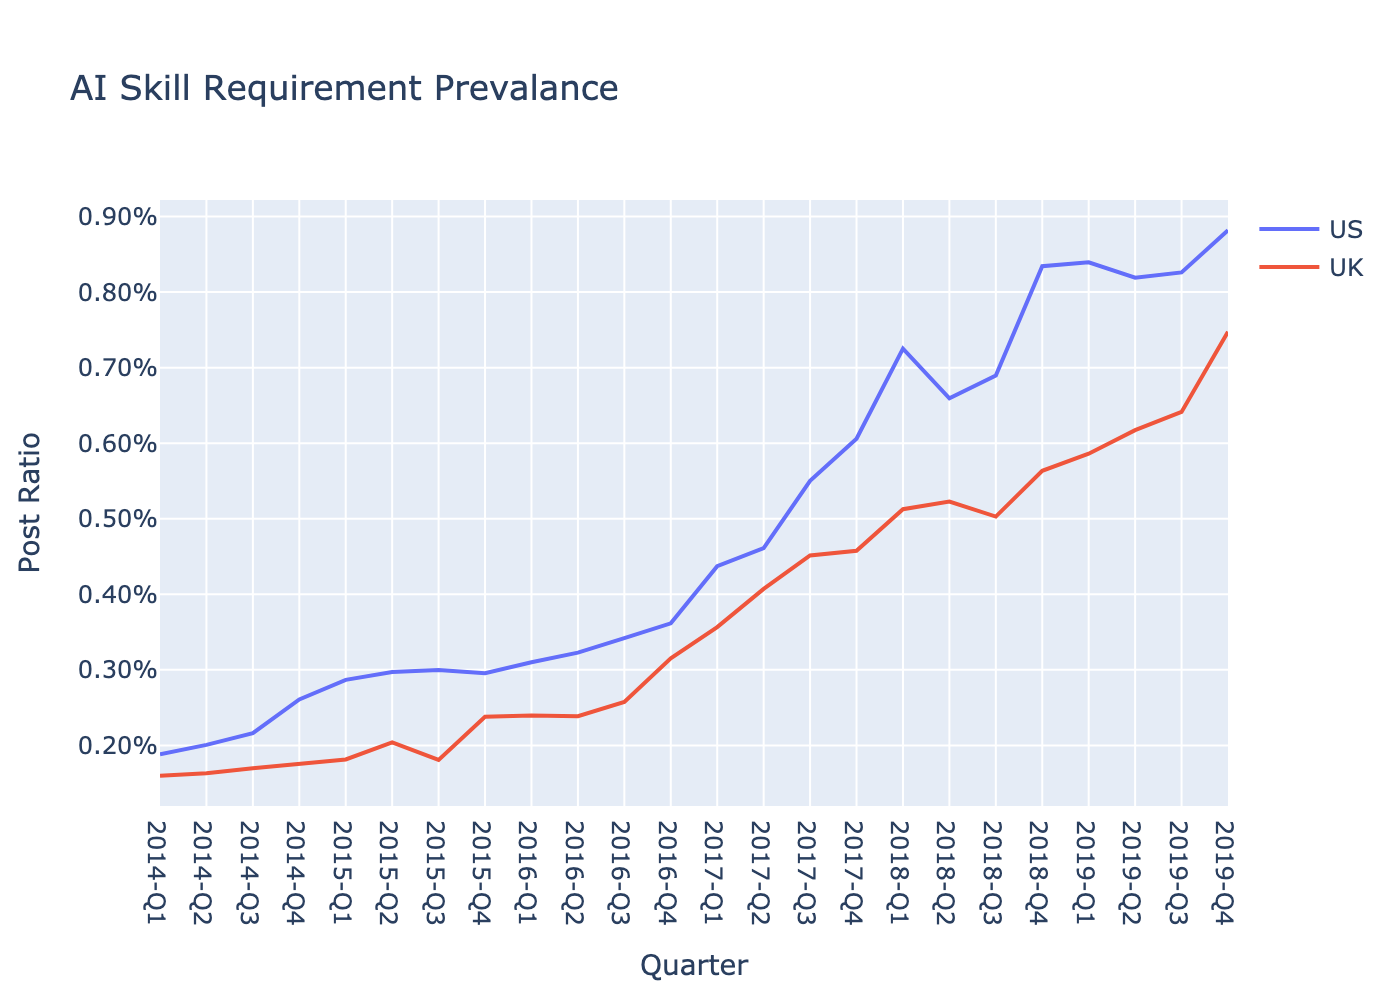

In [4]:
def get_post_ratios(posts_df, skills_df, total_df, skill_list):
    
    post_skill_df = posts_df \
        .join(skills_df, posts_df["ID"] == skills_df["ID"]) \
        .filter(skills_df["SKILL_NAME"].isin(skill_list)) \
        .select(sfunc.year("POSTED").alias("YEAR"), sfunc.quarter("POSTED").alias("QUARTER"), posts_df["ID"]) \
        .group_by(["YEAR", "QUARTER"]) \
        .agg(sfunc.count_distinct(posts_df["ID"]).alias("SKILL_COUNT"))
        
    skill_ratio_df = total_df \
        .join(post_skill_df, ["YEAR", "QUARTER"], "left") \
        .select(sfunc.concat("YEAR", sfunc.concat(sfunc.lit("-Q"), "QUARTER")).alias("QUARTER"), "SKILL_COUNT", "COUNT", (sfunc.col("SKILL_COUNT") / sfunc.col("COUNT")).alias("SKILL_RATIO")) \
        .to_pandas()
    
    return skill_ratio_df

def display_ratios(dataframes, names, title, file_name):
    
    fig = go.Figure()
    
    for i, df in enumerate(dataframes):
        fig.add_trace(go.Scatter(x=df["QUARTER"], y=df["SKILL_RATIO"], mode='lines', name=names[i]))
        
    fig.update_layout(
        title=title, 
        xaxis_title='Quarter', 
        yaxis_title='Post Ratio', 
        width=700, height=500,
        yaxis=dict(tickformat='.2%')
    )
    
    with open(f"figures/{file_name}.png", "wb") as f:
        f.write(fig.to_image(format="png", engine="kaleido", scale=2))
    
    display(IPImage(filename=f"figures/{file_name}.png", width=600, height=500))
        

us_ai_ratio_df = get_post_ratios(us_posts_df, us_skills_df, us_total_posts_df, all_ai_skills)
uk_ai_ratio_df = get_post_ratios(uk_posts_df, uk_skills_df, uk_total_posts_df, all_ai_skills)
    
# plot ai post ratio trends for us and uk
display_ratios([us_ai_ratio_df, uk_ai_ratio_df], ["US", "UK"], "AI Skill Requirement Prevalance", "figure-1")

### Figure 2

After removing the term "Artificial Intelligence" from the Expert Systems category, the ML category is now the fastest growing subcategory with generic terms like "Machine Learning" probably driving this.

**I think a good robustness check will be to rerun all this analysis after removing companies that have >50% of their posts "requiring" an AI skill. Some companies like IBM mention "Deep Learning" in almost all of their posts even for non-AI related jobs**

Regarding how to divide companies by function, rather than technique (i.e. user vs developer skills)
1. We've actually done this internally at my company but we essentially had GPT4 decide which are user vs developer skills. I don't know if that method would be acceptable in a paper. We could do that + use something like mechanical Turk to get human labels and compare though we would probably want higher quality labelers with AI expertise.
2. I think creating a methodologically-robust division between user/developer skills could be quite useful for future projects looking at automation v augmentation, skill demand elasticities, etc. so I think it's worth doing this carefully

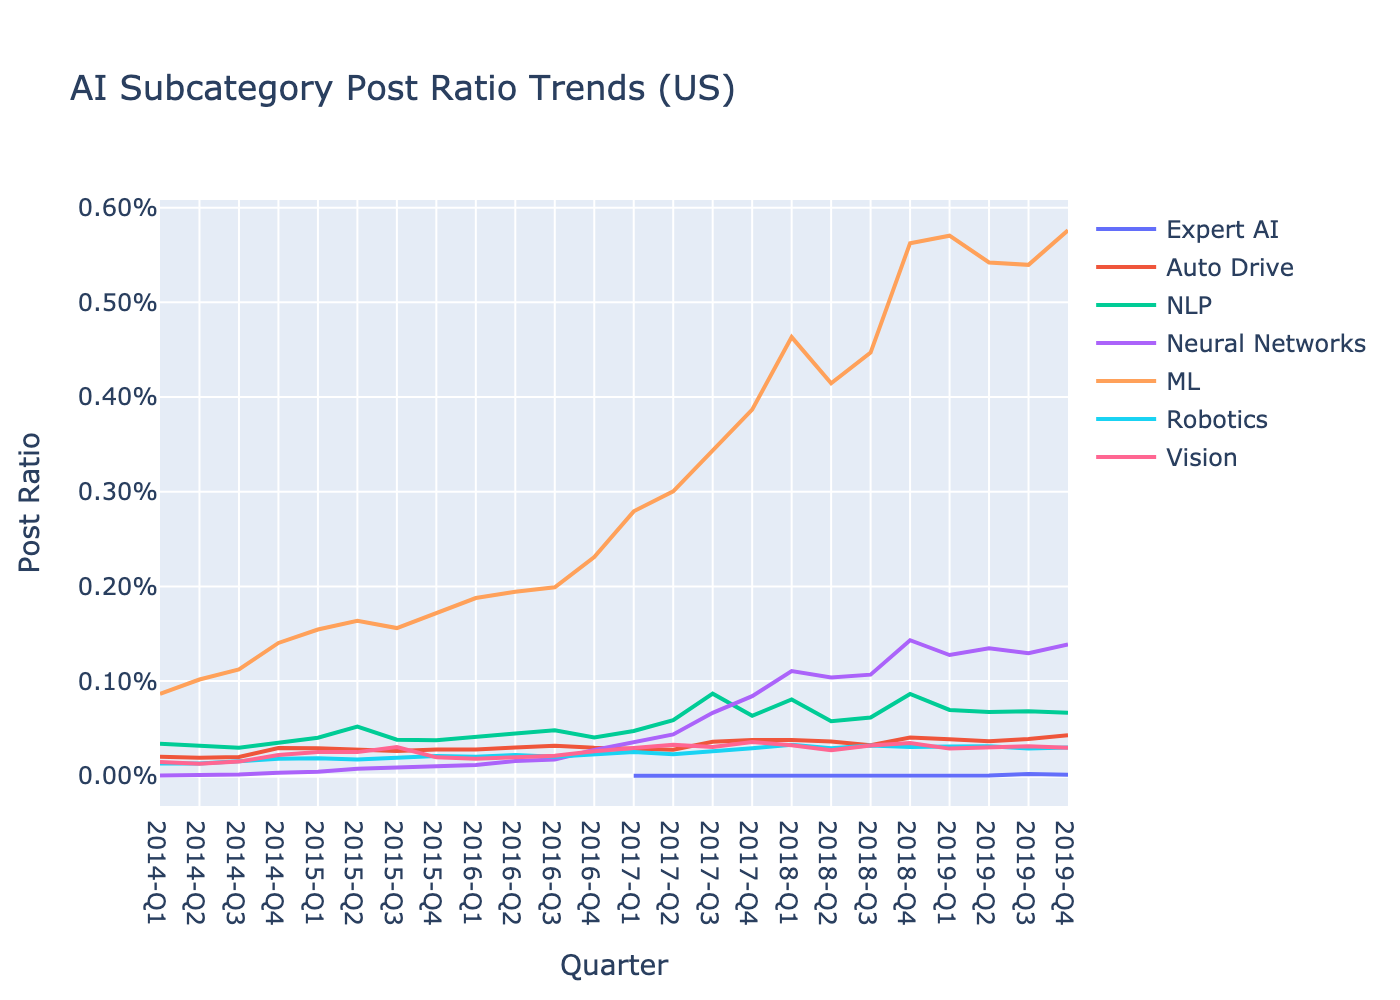

In [5]:
us_genai_ratio_df = get_post_ratios(us_posts_df, us_skills_df, us_total_posts_df, expert_skills)
us_autodrive_ratio_df = get_post_ratios(us_posts_df, us_skills_df, us_total_posts_df, auto_drive_skills)
us_nlp_ratio_df = get_post_ratios(us_posts_df, us_skills_df, us_total_posts_df, nlp_skills)
us_neural_network_ratio_df = get_post_ratios(us_posts_df, us_skills_df, us_total_posts_df, neural_network_skills)
us_ml_ratio_df = get_post_ratios(us_posts_df, us_skills_df, us_total_posts_df, ml_skills)
us_robotics_ratio_df = get_post_ratios(us_posts_df, us_skills_df, us_total_posts_df, robotics_skills)
us_vision_ratio_df = get_post_ratios(us_posts_df, us_skills_df, us_total_posts_df, vision_skills)

# plot ai subcategory post ratio trends for us
display_ratios(
    [us_genai_ratio_df, us_autodrive_ratio_df, us_nlp_ratio_df, us_neural_network_ratio_df, us_ml_ratio_df, us_robotics_ratio_df, us_vision_ratio_df], 
    ["Expert AI", "Auto Drive", "NLP", "Neural Networks", "ML", "Robotics", "Vision"], 
    "AI Subcategory Post Ratio Trends (US)", 
    "figure-2a"
)

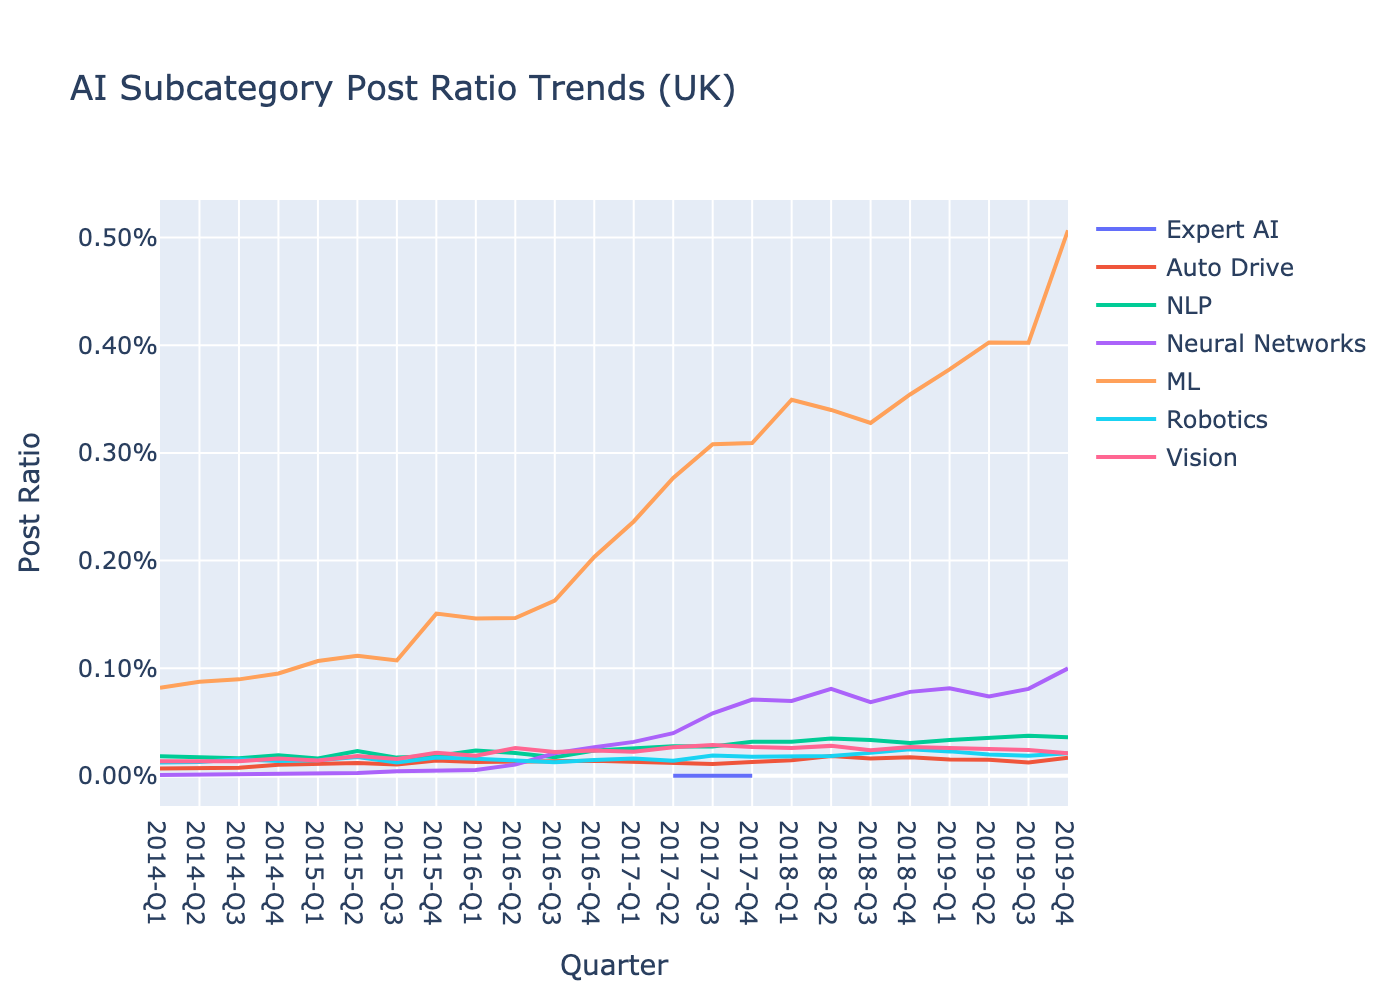

In [6]:
uk_genai_ratio_df = get_post_ratios(uk_posts_df, uk_skills_df, uk_total_posts_df, expert_skills)
uk_autodrive_ratio_df = get_post_ratios(uk_posts_df, uk_skills_df, uk_total_posts_df, auto_drive_skills)
uk_nlp_ratio_df = get_post_ratios(uk_posts_df, uk_skills_df, uk_total_posts_df, nlp_skills)
uk_neural_network_ratio_df = get_post_ratios(uk_posts_df, uk_skills_df, uk_total_posts_df, neural_network_skills)
uk_ml_ratio_df = get_post_ratios(uk_posts_df, uk_skills_df, uk_total_posts_df, ml_skills)
uk_robotics_ratio_df = get_post_ratios(uk_posts_df, uk_skills_df, uk_total_posts_df, robotics_skills)
uk_vision_ratio_df = get_post_ratios(uk_posts_df, uk_skills_df, uk_total_posts_df, vision_skills)

display_ratios(
    [uk_genai_ratio_df, uk_autodrive_ratio_df, uk_nlp_ratio_df, uk_neural_network_ratio_df, uk_ml_ratio_df, uk_robotics_ratio_df, uk_vision_ratio_df], 
    ["Expert AI", "Auto Drive", "NLP", "Neural Networks", "ML", "Robotics", "Vision"], 
    "AI Subcategory Post Ratio Trends (UK)", 
    "figure-2b"
)

### Figure 3

1. In the US, there doesn't seem to be an obvious decrease in degree requirements for all jobs or for AI-jobs, in particular. Except perhaps a slight dip from 2017-2019 for AI jobs.
2. The UK seems to have in increasing demand for Post-Graduate requirements in AI jobs up until 2017 then this begins to dip. The AI trend here could be interpreted as first, a decrease in bachelor-level AI jobs, and increase in post-graduate AI jobs, then a subsequent relaxation in this post-graduate requirement. 

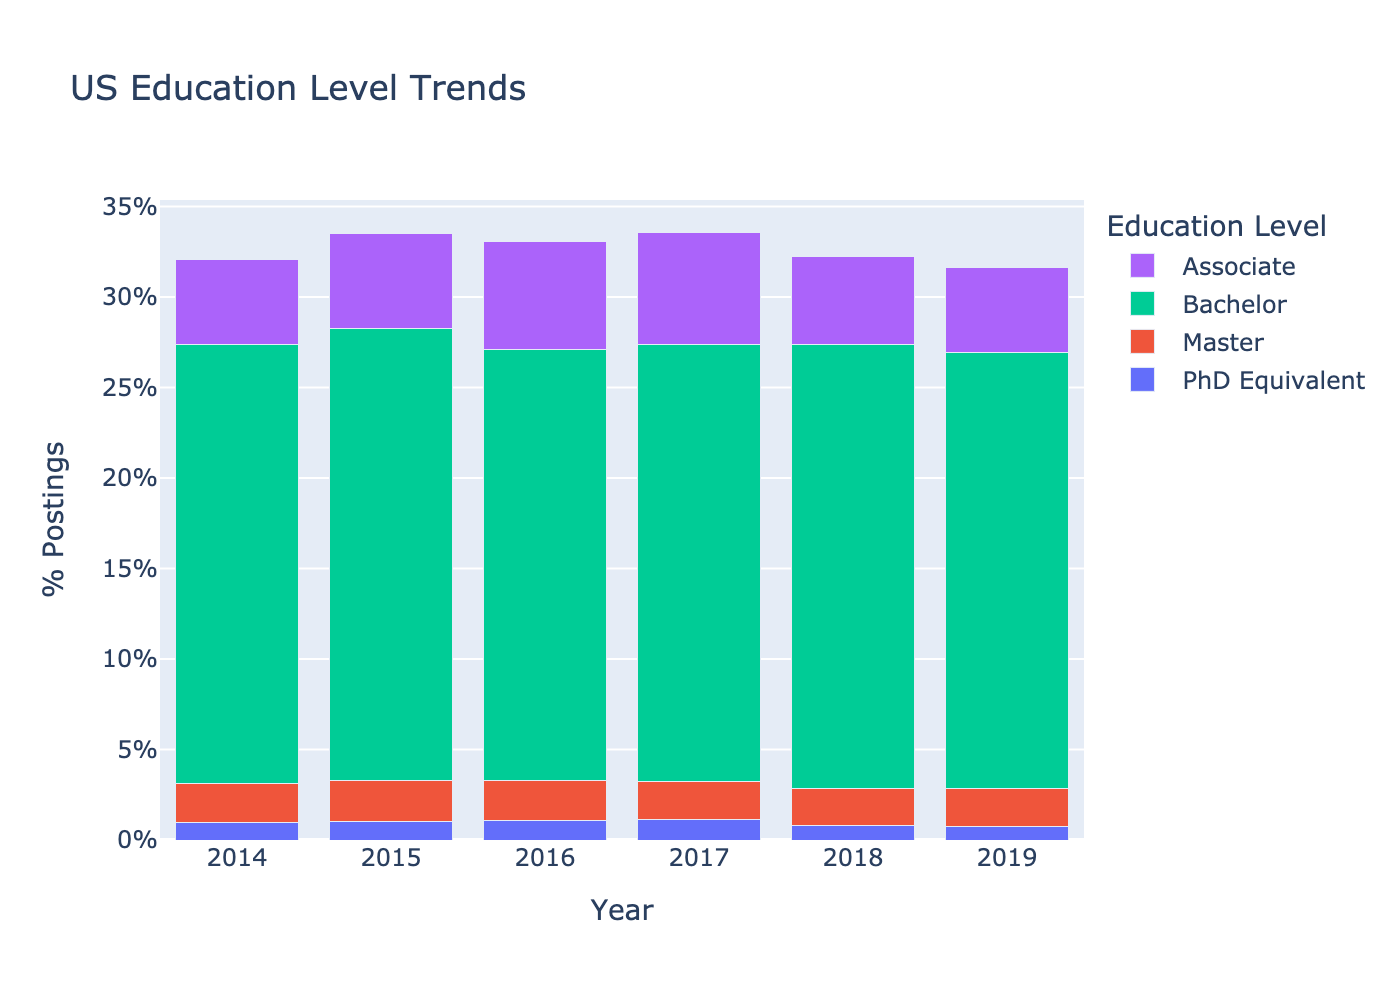

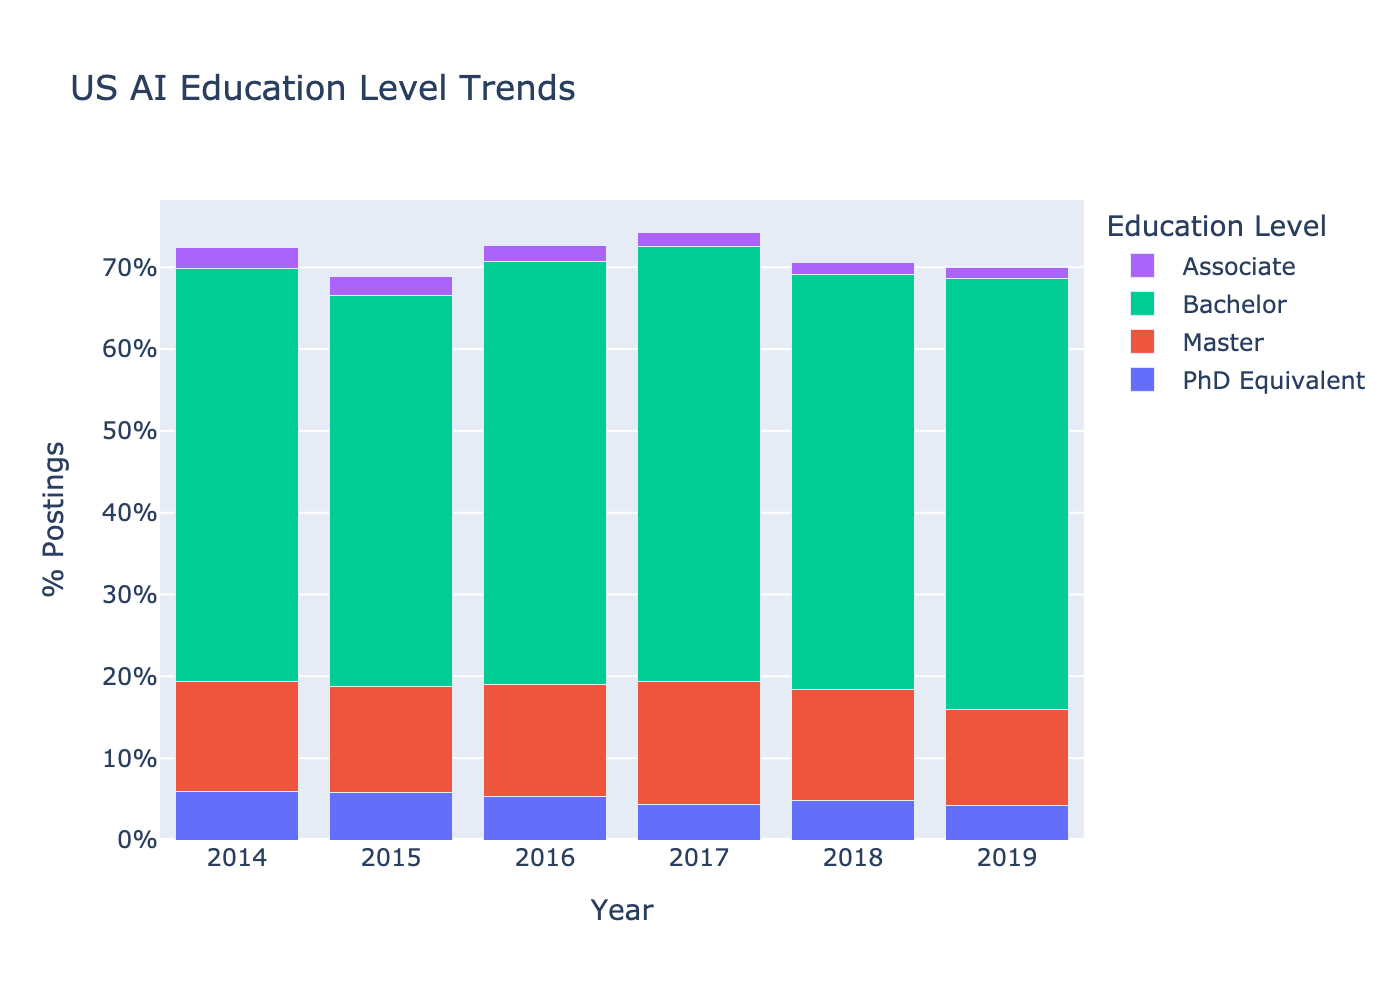

In [7]:
us_nonai_educ_df = us_nonai_posts_df \
    .join(us_skills_df, us_nonai_posts_df["ID"] == us_skills_df["ID"]) \
    .select(sfunc.year("POSTED").alias("YEAR"), us_nonai_posts_df["MIN_EDULEVELS_NAME"], us_nonai_posts_df["ID"]) \
    .group_by(["YEAR", "MIN_EDULEVELS_NAME"]) \
    .agg(sfunc.count_distinct(us_nonai_posts_df["ID"]).alias("SKILL_COUNT")) \
    .select("YEAR", "MIN_EDULEVELS_NAME", sfunc.cast("SKILL_COUNT", stypes.FloatType()).alias("SKILL_COUNT")) \
    .order_by("YEAR") \
    .to_pandas()

us_ai_educ_df = us_ai_posts_df \
    .select(sfunc.year("POSTED").alias("YEAR"), us_ai_posts_df["MIN_EDULEVELS_NAME"], us_ai_posts_df["ID"]) \
    .group_by(["YEAR", "MIN_EDULEVELS_NAME"]) \
    .agg(sfunc.count_distinct(us_ai_posts_df["ID"]).alias("SKILL_COUNT")) \
    .select("YEAR", "MIN_EDULEVELS_NAME", sfunc.cast("SKILL_COUNT", stypes.FloatType()).alias("SKILL_COUNT")) \
    .order_by("YEAR") \
    .to_pandas()
    
us_pivot_df = us_nonai_educ_df.pivot(index="YEAR", columns="MIN_EDULEVELS_NAME", values="SKILL_COUNT").fillna(0).reset_index()
us_pivot_df.iloc[:, 1:] = us_pivot_df.iloc[:, 1:].div(us_pivot_df.iloc[:, 1:].sum(axis=1), axis=0)
us_pivot_df = us_pivot_df[["YEAR", "Ph.D. or professional degree", "Master's degree", "Bachelor's degree", "Associate degree"]]
us_pivot_df.columns = ["YEAR", "PhD Equivalent", "Master", "Bachelor", "Associate"]

us_ai_pivot_df = us_ai_educ_df.pivot(index="YEAR", columns="MIN_EDULEVELS_NAME", values="SKILL_COUNT").fillna(0).reset_index()
us_ai_pivot_df.iloc[:, 1:] = us_ai_pivot_df.iloc[:, 1:].div(us_ai_pivot_df.iloc[:, 1:].sum(axis=1), axis=0)
us_ai_pivot_df = us_ai_pivot_df[["YEAR", "Ph.D. or professional degree", "Master's degree", "Bachelor's degree", "Associate degree"]]
us_ai_pivot_df.columns = ["YEAR", "PhD Equivalent", "Master", "Bachelor", "Associate"]

def display_education(df, title, file_name):
    
    fig = go.Figure()
    
    for education_level in df.columns[1:]:
        fig.add_trace(go.Bar(
            x=df["YEAR"],
            y=df[education_level],
            name=education_level
        ))

    fig.update_layout(
        barmode='stack',
        title=title,
        xaxis_title='Year',
        yaxis_title='% Postings',
        legend_title='Education Level',
        width=700, height=500,
        yaxis=dict(tickformat='.0%')
    )
    
    with open(f"figures/{file_name}.png", "wb") as f:
        f.write(fig.to_image(format="png", engine="kaleido", scale=2))
        
    display(IPImage(filename=f"figures/{file_name}.png", width=700, height=500))
    
    
display_education(us_pivot_df, "US Education Level Trends", "figure-3a")
display_education(us_ai_pivot_df, "US AI Education Level Trends", "figure-3b")

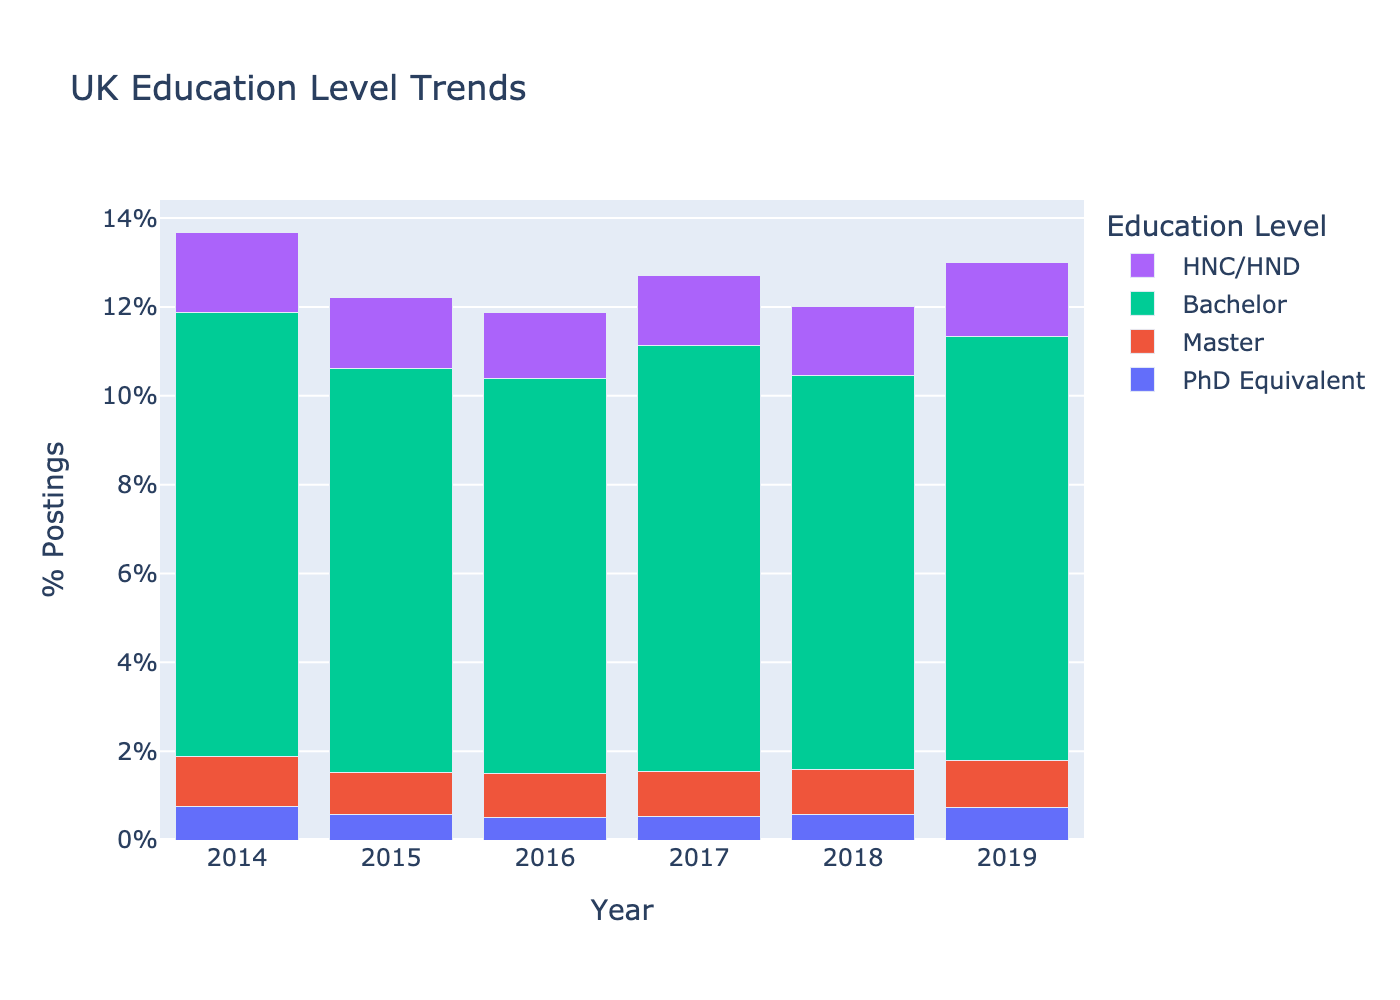

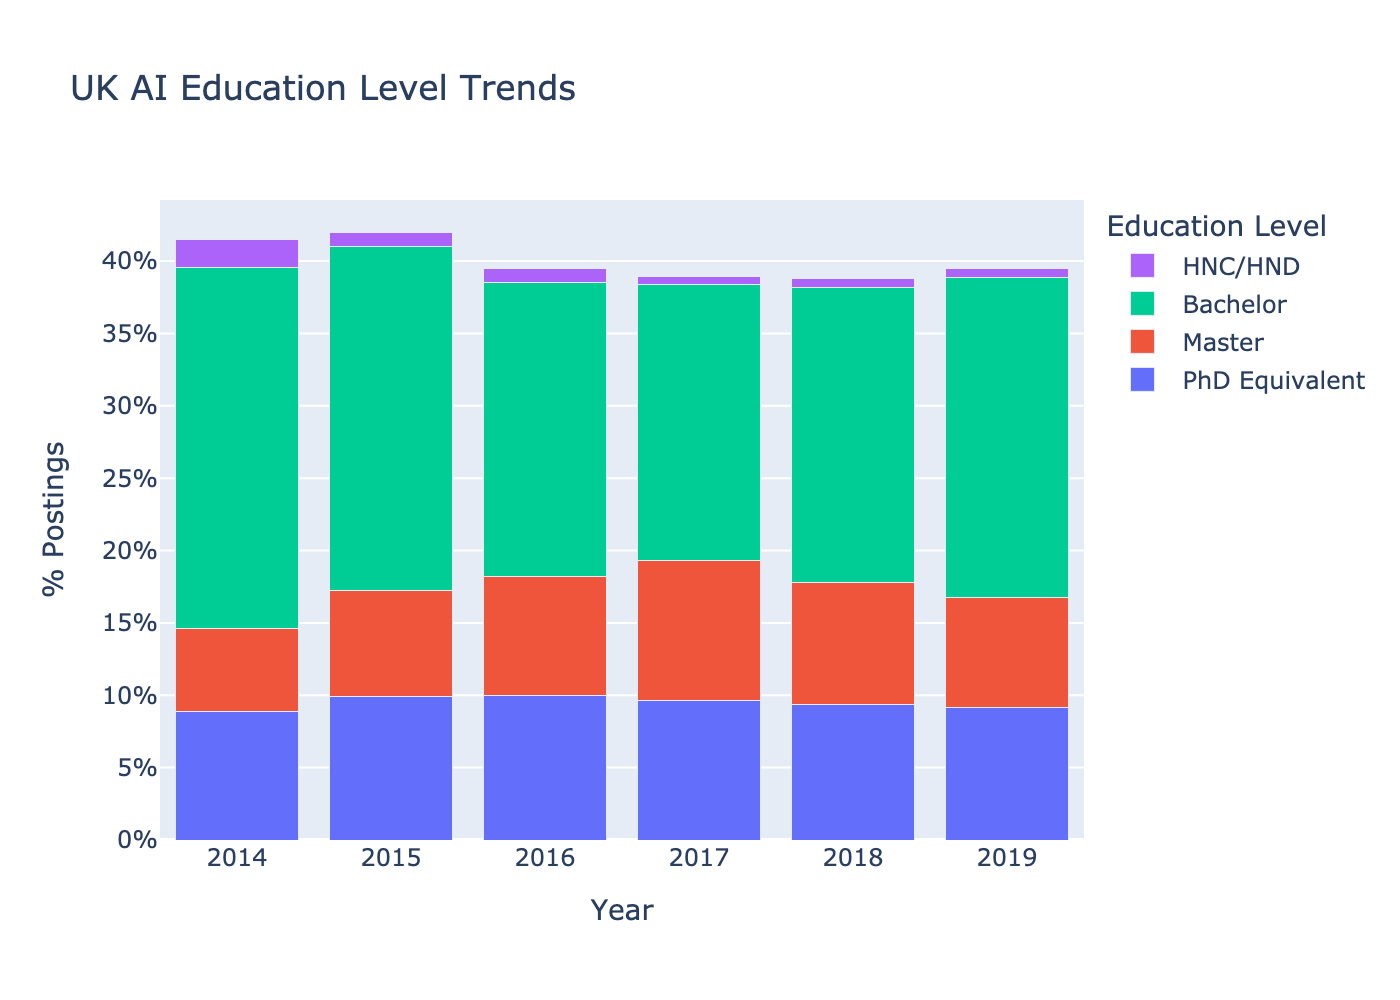

In [8]:
uk_nonai_educ_df = uk_nonai_posts_df \
    .join(uk_skills_df, uk_nonai_posts_df["ID"] == uk_skills_df["ID"]) \
    .select(sfunc.year("POSTED").alias("YEAR"), uk_nonai_posts_df["EDULEVELS_NAME_MIN"], uk_nonai_posts_df["ID"]) \
    .group_by(["YEAR", "EDULEVELS_NAME_MIN"]) \
    .agg(sfunc.count_distinct(uk_nonai_posts_df["ID"]).alias("SKILL_COUNT")) \
    .select("YEAR", "EDULEVELS_NAME_MIN", sfunc.cast("SKILL_COUNT", stypes.FloatType()).alias("SKILL_COUNT")) \
    .order_by("YEAR") \
    .to_pandas()
    
uk_ai_educ_df = uk_ai_posts_df \
    .select(sfunc.year("POSTED").alias("YEAR"), uk_ai_posts_df["EDULEVELS_NAME_MIN"], uk_ai_posts_df["ID"]) \
    .group_by(["YEAR", "EDULEVELS_NAME_MIN"]) \
    .agg(sfunc.count_distinct(uk_ai_posts_df["ID"]).alias("SKILL_COUNT")) \
    .select("YEAR", "EDULEVELS_NAME_MIN", sfunc.cast("SKILL_COUNT", stypes.FloatType()).alias("SKILL_COUNT")) \
    .order_by("YEAR") \
    .to_pandas()
    
uk_pivot_df = uk_nonai_educ_df.pivot(index="YEAR", columns="EDULEVELS_NAME_MIN", values="SKILL_COUNT").fillna(0).reset_index()
uk_pivot_df.iloc[:, 1:] = uk_pivot_df.iloc[:, 1:].div(uk_pivot_df.iloc[:, 1:].sum(axis=1), axis=0)
uk_pivot_df = uk_pivot_df[["YEAR", "Ph.D. or equivalent", "Master's or equivalent", "Bachelor's or equivalent", "Foundation/HNC/HND or equivalent"]]
uk_pivot_df.columns = ["YEAR", "PhD Equivalent", "Master", "Bachelor", "HNC/HND"]

uk_ai_pivot_df = uk_ai_educ_df.pivot(index="YEAR", columns="EDULEVELS_NAME_MIN", values="SKILL_COUNT").fillna(0).reset_index()
uk_ai_pivot_df.iloc[:, 1:] = uk_ai_pivot_df.iloc[:, 1:].div(uk_ai_pivot_df.iloc[:, 1:].sum(axis=1), axis=0)
uk_ai_pivot_df = uk_ai_pivot_df[["YEAR", "Ph.D. or equivalent", "Master's or equivalent", "Bachelor's or equivalent", "Foundation/HNC/HND or equivalent"]]
uk_ai_pivot_df.columns = ["YEAR", "PhD Equivalent", "Master", "Bachelor", "HNC/HND"]

display_education(uk_pivot_df, "UK Education Level Trends", "figure-3c")
display_education(uk_ai_pivot_df, "UK AI Education Level Trends", "figure-3d")

### Figure 4

This show a few interesting things:
1. The US and UK have a relatively similar AI wage premium (~2x)
2. In the US, average AI wages are similar to the wages of a PhD, slightly less. Whereas in the UK, AI wages start below but then quickly go over the average wages of a PhD

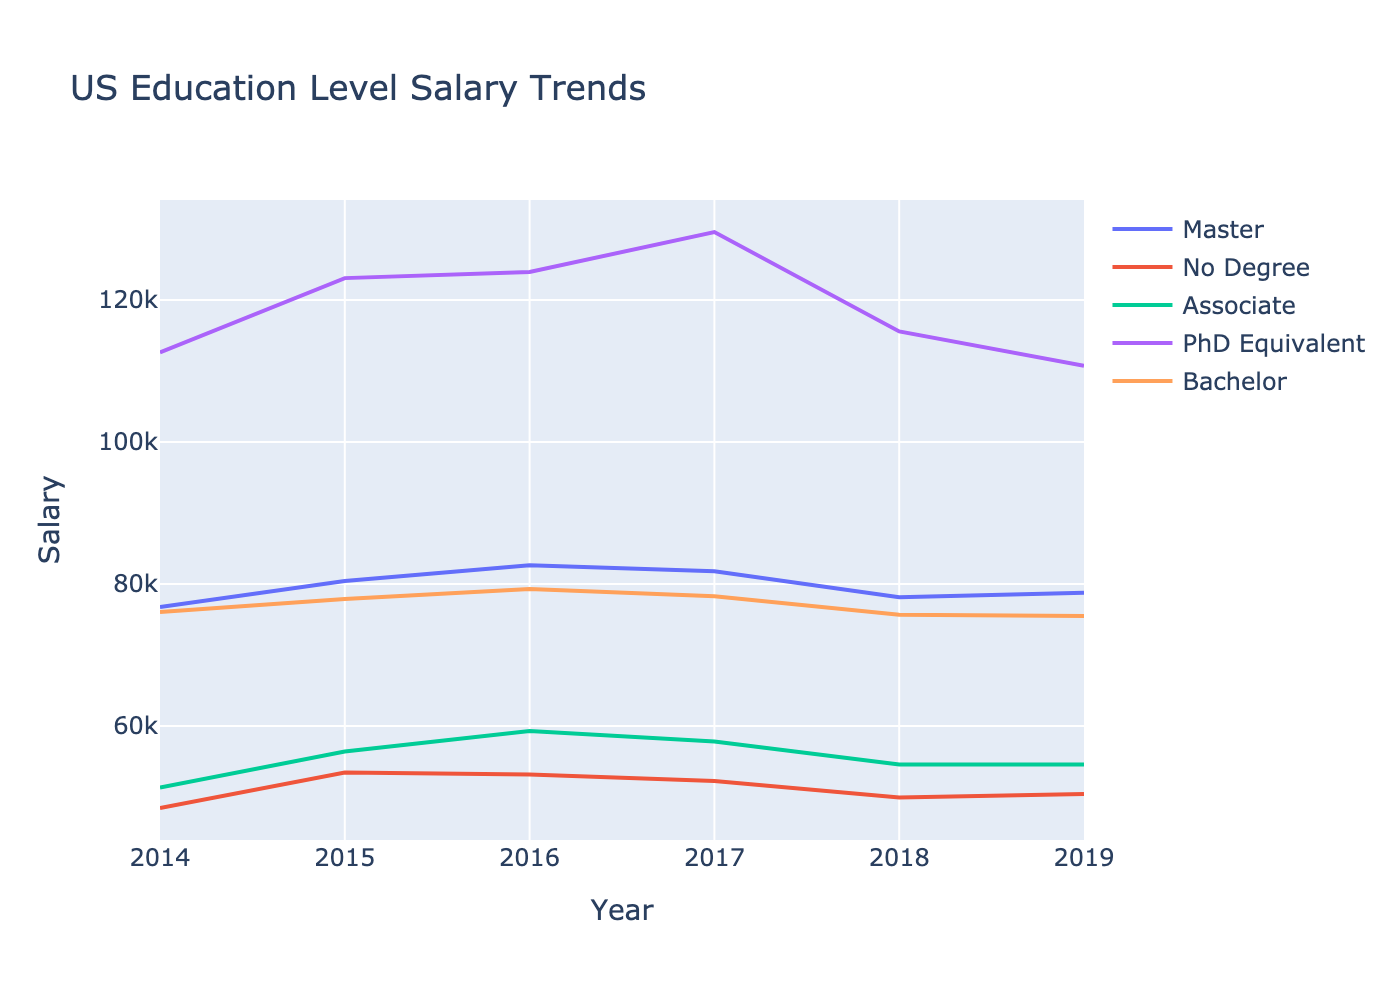

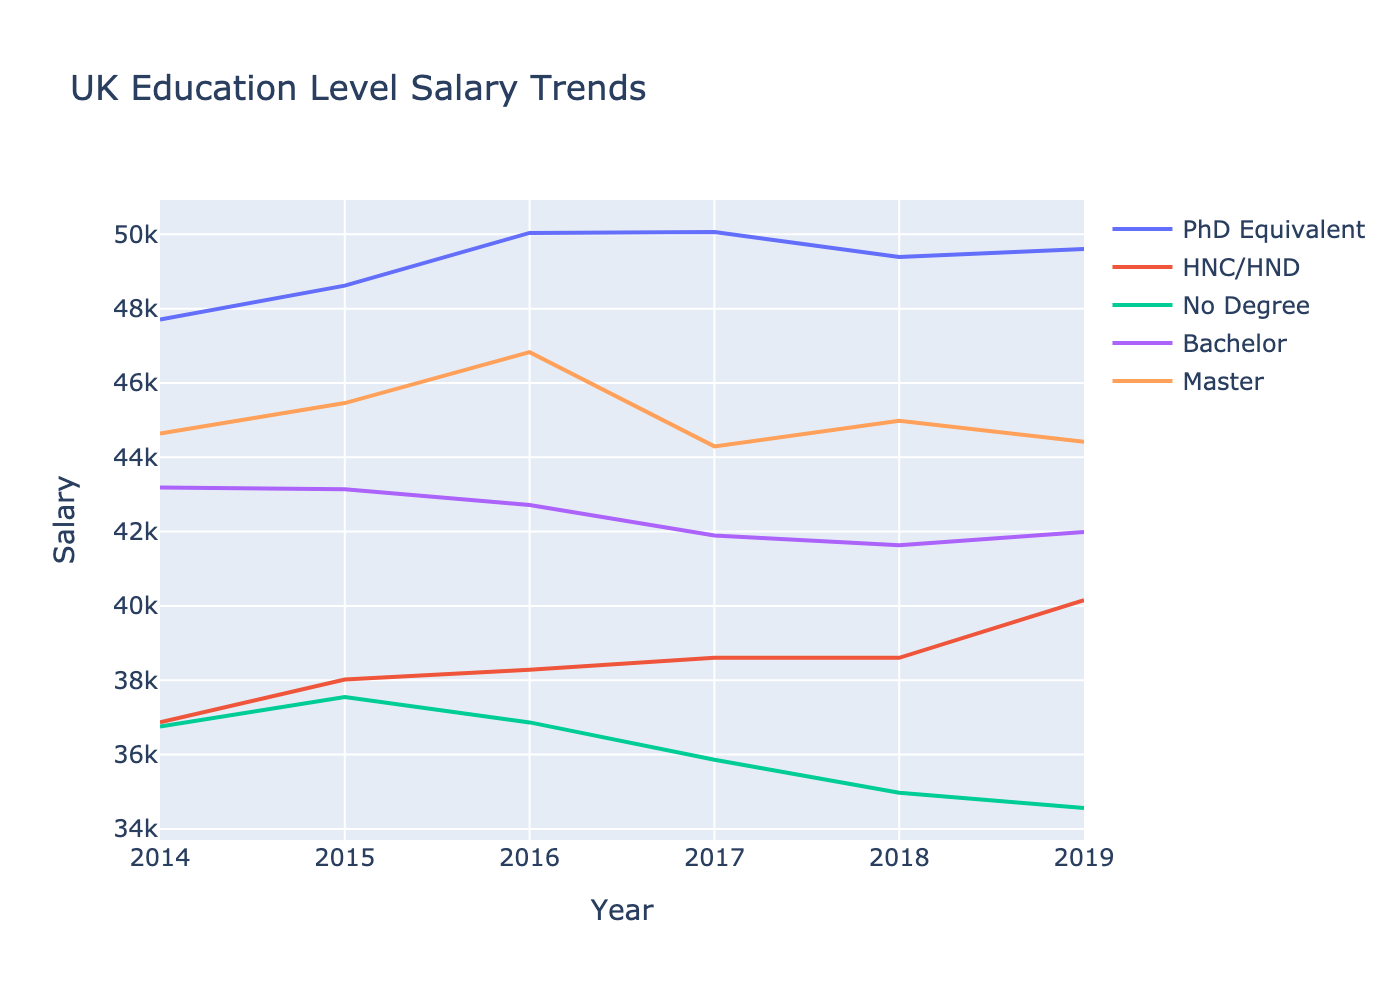

In [9]:
us_educ_wage_df = us_posts_df.with_column(
        "MIN_EDULEVELS_NAME",
        sfunc.when(sfunc.col("MIN_EDULEVELS_NAME") == "No Education Listed", "No Degree")
        .when(sfunc.col("MIN_EDULEVELS_NAME") == "High school or GED", "No Degree")
        .when(sfunc.col("MIN_EDULEVELS_NAME") == "Associate degree", "Associate")
        .when(sfunc.col("MIN_EDULEVELS_NAME") == "Bachelor's degree", "Bachelor")
        .when(sfunc.col("MIN_EDULEVELS_NAME") == "Master's degree", "Master")
        .when(sfunc.col("MIN_EDULEVELS_NAME") == "Ph.D. or professional degree", "PhD Equivalent")
        .otherwise(sfunc.col("MIN_EDULEVELS_NAME"))  # Fallback to the original value if not in the map
    ) \
    .select(sfunc.year("POSTED").alias("YEAR"), us_posts_df["MIN_EDULEVELS_NAME"].alias("EDUCATION"), "SALARY") \
    .group_by(["YEAR", "EDUCATION"]) \
    .agg(sfunc.avg("SALARY").alias("SALARY")) \
    .order_by("YEAR") \
    .to_pandas()
    
uk_educ_wage_df = uk_posts_df.with_column(
        "EDULEVELS_NAME_MIN",
        sfunc.when(sfunc.col("EDULEVELS_NAME_MIN") == "No Education Listed", "No Degree")
        .when(sfunc.col("EDULEVELS_NAME_MIN") == "A-levels or equivalent", "No Degree")
        .when(sfunc.col("EDULEVELS_NAME_MIN") == "Up to GCSEs or equivalent", "No Degree")
        .when(sfunc.col("EDULEVELS_NAME_MIN") == "Foundation/HNC/HND or equivalent", "HNC/HND")
        .when(sfunc.col("EDULEVELS_NAME_MIN") == "Bachelor's or equivalent", "Bachelor")
        .when(sfunc.col("EDULEVELS_NAME_MIN") == "Master's or equivalent", "Master")
        .when(sfunc.col("EDULEVELS_NAME_MIN") == "Ph.D. or equivalent", "PhD Equivalent")
        .otherwise(sfunc.col("EDULEVELS_NAME_MIN"))  # Fallback to the original value if not in the map
    ) \
    .select(sfunc.year("POSTED").alias("YEAR"), uk_posts_df["EDULEVELS_NAME_MIN"].alias("EDUCATION"), "SALARY") \
    .group_by(["YEAR", "EDUCATION"]) \
    .agg(sfunc.avg("SALARY").alias("SALARY")) \
    .order_by("YEAR") \
    .to_pandas()

def display_educ_wages(df, title, file_name):
    
    fig = go.Figure()
    
    education_levels = df["EDUCATION"].unique()   
    
    for education_level in education_levels:
        fig.add_trace(go.Scatter(x=df[df["EDUCATION"] == education_level]["YEAR"], y=df[df["EDUCATION"] == education_level]["SALARY"], mode='lines', name=education_level))
        
    fig.update_layout(
        title=title,
        xaxis_title='Year',
        yaxis_title='Salary',
        width=700, height=500
    )
    
    with open(f"figures/{file_name}.png", "wb") as f:
        f.write(fig.to_image(format="png", engine="kaleido", scale=2))
        
    display(IPImage(filename=f"figures/{file_name}.png", width=700, height=500))

display_educ_wages(us_educ_wage_df, "US Education Level Salary Trends", "figure-4a")
display_educ_wages(uk_educ_wage_df, "UK Education Level Salary Trends", "figure-4b")

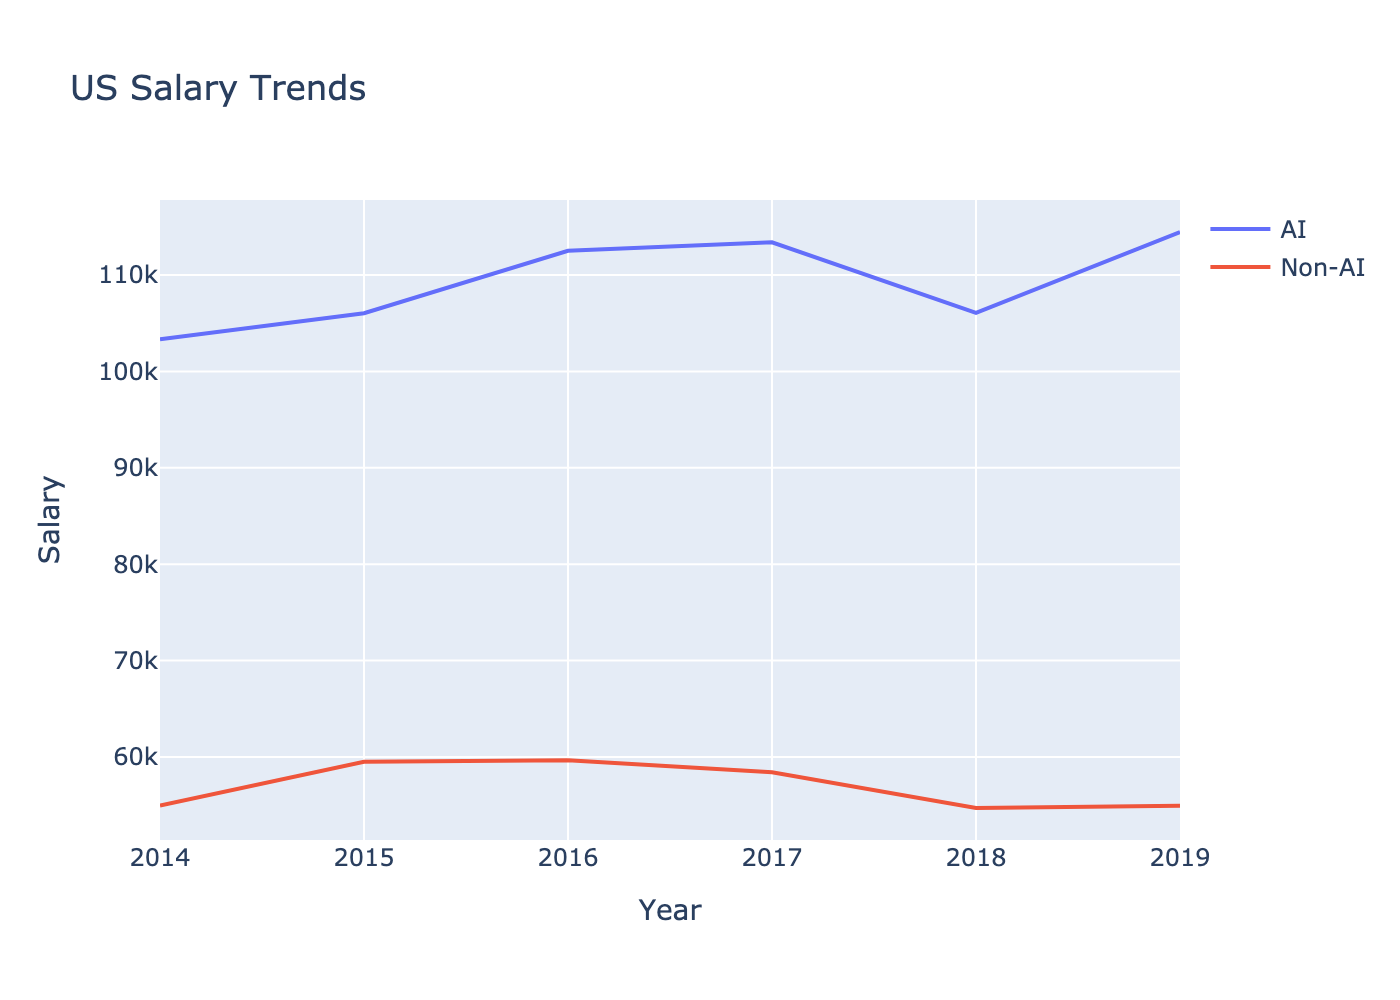

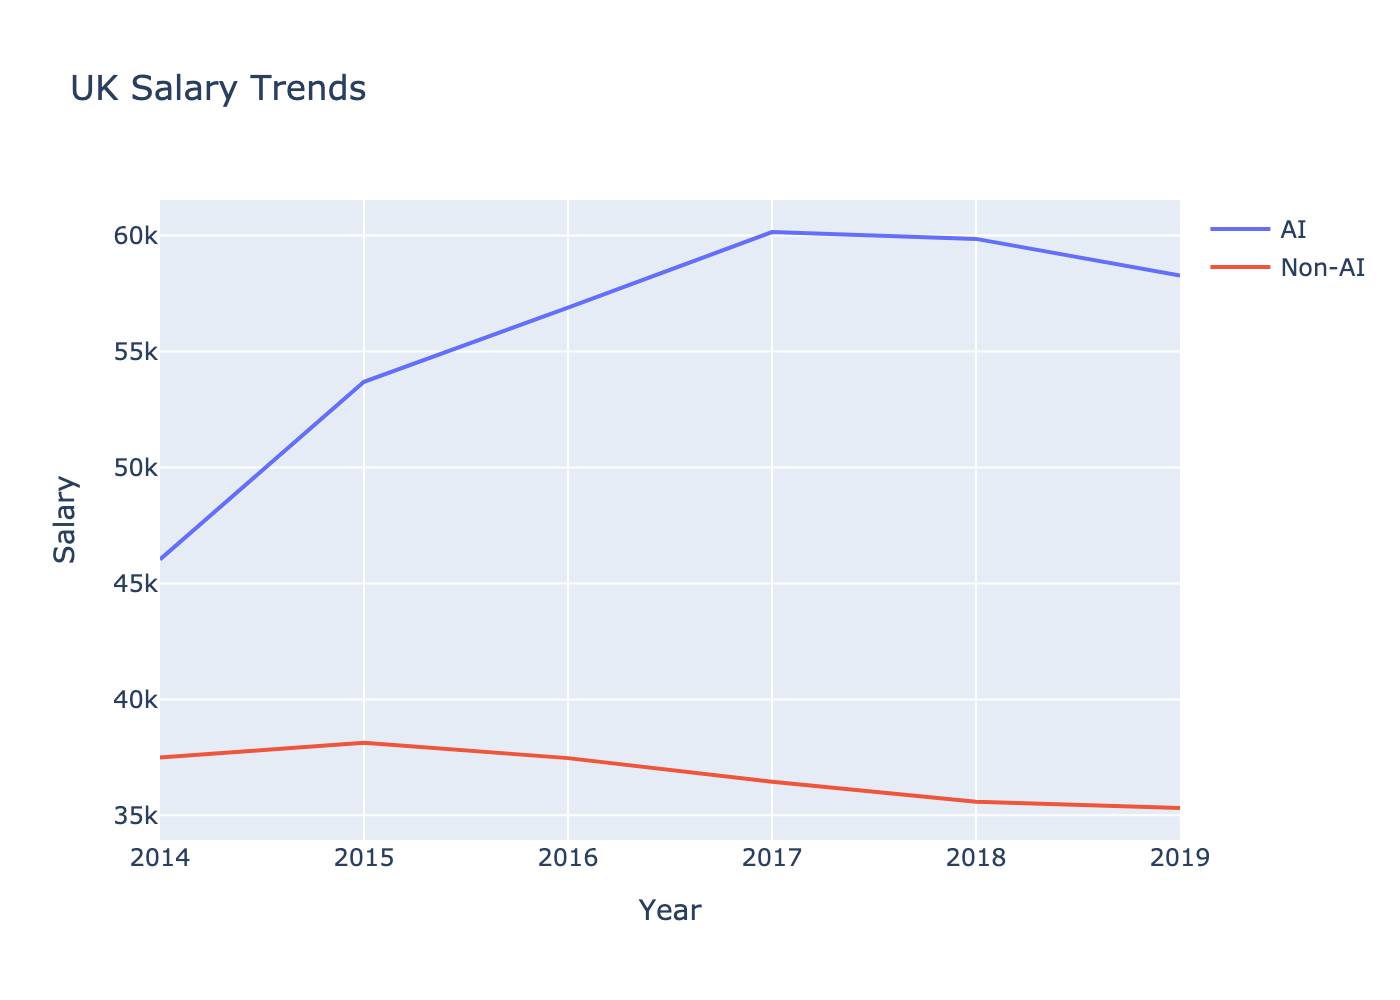

In [10]:
us_ai_wage_df = us_ai_posts_df \
    .select(sfunc.year("POSTED").alias("YEAR"), "SALARY") \
    .group_by("YEAR") \
    .agg(sfunc.avg("SALARY").alias("SALARY")) \
    .order_by("YEAR") \
    .to_pandas()

us_nonai_wage_df = us_nonai_posts_df \
    .select(sfunc.year("POSTED").alias("YEAR"), "SALARY") \
    .group_by("YEAR") \
    .agg(sfunc.avg("SALARY").alias("SALARY")) \
    .order_by("YEAR") \
    .to_pandas()
    
uk_ai_wage_df = uk_ai_posts_df \
    .select(sfunc.year("POSTED").alias("YEAR"), "SALARY") \
    .group_by("YEAR") \
    .agg(sfunc.avg("SALARY").alias("SALARY")) \
    .order_by("YEAR") \
    .to_pandas()
    
uk_nonai_wage_df = uk_nonai_posts_df \
    .select(sfunc.year("POSTED").alias("YEAR"), "SALARY") \
    .group_by("YEAR") \
    .agg(sfunc.avg("SALARY").alias("SALARY")) \
    .order_by("YEAR") \
    .to_pandas()
    
def display_wages(dataframes, names, title, file_name):
    
    fig = go.Figure()
    
    for i, df in enumerate(dataframes):
        fig.add_trace(go.Scatter(x=df["YEAR"], y=df["SALARY"], mode='lines', name=names[i]))
        
    fig.update_layout(
        title=title,
        xaxis_title='Year',
        yaxis_title='Salary',
        width=700, height=500
    )
    
    with open(f"figures/{file_name}.png", "wb") as f:
        f.write(fig.to_image(format="png", engine="kaleido", scale=2))
        
    display(IPImage(filename=f"figures/{file_name}.png", width=700, height=500))
    
display_wages([us_ai_wage_df, us_nonai_wage_df], ["AI", "Non-AI"], "US Salary Trends", "figure-4c")
display_wages([uk_ai_wage_df, uk_nonai_wage_df], ["AI", "Non-AI"], "UK Salary Trends", "figure-4d")

# Regression Analysis

In [11]:
us_ai_reg_df = us_ai_posts_df \
    .select(
        "ID",
        "SALARY", 
        "MIN_YEARS_EXPERIENCE",
        sfunc.call_builtin("ifnull", sfunc.col("MIN_EDULEVELS_NAME"), "No Education Listed").alias("MIN_EDULEVELS_NAME"),
        sfunc.year("POSTED").alias("YEAR"), 
        sfunc.call_builtin("ifnull", sfunc.col("NAICS_2022_2_NAME"), "Unclassified Industry").alias("NAICS_2022_2_NAME"),
        sfunc.call_builtin("ifnull", sfunc.col("SOC_2_NAME"), "NULL").alias("SOC_2_NAME"),
        sfunc.call_builtin("ifnull", sfunc.col("STATE"), "NULL").alias("STATE"),
        sfunc.array_size(us_ai_posts_df["SKILLS"]).alias("SKILL_COUNT"),
        sfunc.col("MIN_EDULEVELS_NAME").isin(["Ph.D. or professional degree", "Master's degree", "Bachelor's degree", "Associate degree"]).alias("DEGREE"),
        sfunc.col("MIN_EDULEVELS_NAME").isin(["Ph.D. or professional degree", "Master's degree"]).alias("POSTGRAD_DEGREE"),
        sfunc.col("MIN_YEARS_EXPERIENCE").between(0, 5).alias("EXP_0_5"),
        sfunc.col("MIN_YEARS_EXPERIENCE").between(6, np.inf).alias("EXP_6_PLUS")
    ) \
    .withColumn("AI_SKILL", sfunc.lit(1))
    
us_nonai_reg_df = us_nonai_posts_df \
    .select(
         "ID",
        "SALARY", 
        "MIN_YEARS_EXPERIENCE",
        sfunc.call_builtin("ifnull", sfunc.col("MIN_EDULEVELS_NAME"), "No Education Listed").alias("MIN_EDULEVELS_NAME"),
        sfunc.year("POSTED").alias("YEAR"), 
        sfunc.call_builtin("ifnull", sfunc.col("NAICS_2022_2_NAME"), "Unclassified Industry").alias("NAICS_2022_2_NAME"),
        sfunc.call_builtin("ifnull", sfunc.col("SOC_2_NAME"), "NULL").alias("SOC_2_NAME"),
        sfunc.call_builtin("ifnull", sfunc.col("STATE"), "NULL").alias("STATE"),
        sfunc.array_size(us_nonai_posts_df["SKILLS"]).alias("SKILL_COUNT"),
        sfunc.col("MIN_EDULEVELS_NAME").isin(["Ph.D. or professional degree", "Master's degree", "Bachelor's degree", "Associate degree"]).alias("DEGREE"),
        sfunc.col("MIN_EDULEVELS_NAME").isin(["Ph.D. or professional degree", "Master's degree"]).alias("POSTGRAD_DEGREE"),
        sfunc.col("MIN_YEARS_EXPERIENCE").between(0, 4).alias("EXP_0_4"),
        sfunc.col("MIN_YEARS_EXPERIENCE").between(5, np.inf).alias("EXP_5_PLUS")
    ) \
    .withColumn("AI_SKILL", sfunc.lit(0))

uk_ai_reg_df = uk_ai_posts_df \
    .select(
         "ID",
        "SALARY", 
        "MIN_YEARS_EXPERIENCE",
        sfunc.call_builtin("ifnull", sfunc.col("EDULEVELS_NAME_MIN"), "No Education Listed").alias("EDULEVELS_NAME_MIN"),
        sfunc.year("POSTED").alias("YEAR"), 
        sfunc.call_builtin("ifnull", sfunc.col("UK_SIC_1_NAME"), "NULL").alias("UK_SIC_1_NAME"),
        sfunc.call_builtin("ifnull", sfunc.col("SOC_1_NAME"), "NULL").alias("SOC_1_NAME"),
        sfunc.call_builtin("ifnull", sfunc.col("NUTS1_NAME"), "NULL").alias("NUTS1_NAME"),
        sfunc.array_size(uk_ai_posts_df["SKILLS"]).alias("SKILL_COUNT"),
        sfunc.col("EDULEVELS_NAME_MIN").isin(["Ph.D. or equivalent", "Master's or equivalent", "Bachelor's or equivalent", "Foundation/HNC/HND or equivalent"]).alias("DEGREE"),
        sfunc.col("EDULEVELS_NAME_MIN").isin(["Ph.D. or equivalent", "Master's or equivalent"]).alias("POSTGRAD_DEGREE"),
        sfunc.col("MIN_YEARS_EXPERIENCE").between(0, 4).alias("EXP_0_4"),
        sfunc.col("MIN_YEARS_EXPERIENCE").between(5, np.inf).alias("EXP_5_PLUS")
    ) \
    .withColumn("AI_SKILL", sfunc.lit(1))
    
uk_nonai_reg_df = uk_nonai_posts_df \
    .select(
         "ID",
        "SALARY", 
        "MIN_YEARS_EXPERIENCE",
        sfunc.call_builtin("ifnull", sfunc.col("EDULEVELS_NAME_MIN"), "No Education Listed").alias("EDULEVELS_NAME_MIN"),
        sfunc.year("POSTED").alias("YEAR"), 
        sfunc.call_builtin("ifnull", sfunc.col("UK_SIC_1_NAME"), "NULL").alias("UK_SIC_1_NAME"),
        sfunc.call_builtin("ifnull", sfunc.col("SOC_1_NAME"), "NULL").alias("SOC_1_NAME"),
        sfunc.call_builtin("ifnull", sfunc.col("NUTS1_NAME"), "NULL").alias("NUTS1_NAME"),
        sfunc.array_size(uk_nonai_posts_df["SKILLS"]).alias("SKILL_COUNT"),
        sfunc.col("EDULEVELS_NAME_MIN").isin(["Ph.D. or equivalent", "Master's or equivalent", "Bachelor's or equivalent", "Foundation/HNC/HND or equivalent"]).alias("DEGREE"),
        sfunc.col("EDULEVELS_NAME_MIN").isin(["Ph.D. or equivalent", "Master's or equivalent"]).alias("POSTGRAD_DEGREE"),
        sfunc.col("MIN_YEARS_EXPERIENCE").between(0, 4).alias("EXP_0_4"),
        sfunc.col("MIN_YEARS_EXPERIENCE").between(5, np.inf).alias("EXP_5_PLUS")
    ) \
    .withColumn("AI_SKILL", sfunc.lit(0))
   
us_reg_df = us_ai_reg_df.union(us_nonai_reg_df).to_pandas().sample(frac=1)
uk_reg_df = uk_ai_reg_df.union(uk_nonai_reg_df).to_pandas().sample(frac=1)

In [12]:
us_reg_df["LOG_SALARY"] = np.log(us_reg_df["SALARY"])
uk_reg_df["LOG_SALARY"] = np.log(uk_reg_df["SALARY"])

us_reg_df["LOG_SKILL_COUNT"] = np.log(us_reg_df["SKILL_COUNT"] + 1)
uk_reg_df["LOG_SKILL_COUNT"] = np.log(uk_reg_df["SKILL_COUNT"] + 1)

In [13]:
print("There are {} US AI posts and {} US non-AI posts".format(us_ai_reg_df.count(), us_nonai_reg_df.count()))
print("There are {} UK AI posts and {} UK non-AI posts".format(uk_ai_reg_df.count(), uk_nonai_reg_df.count()))

There are 104522 US AI posts and 19889709 US non-AI posts
There are 74608 UK AI posts and 19928139 UK non-AI posts


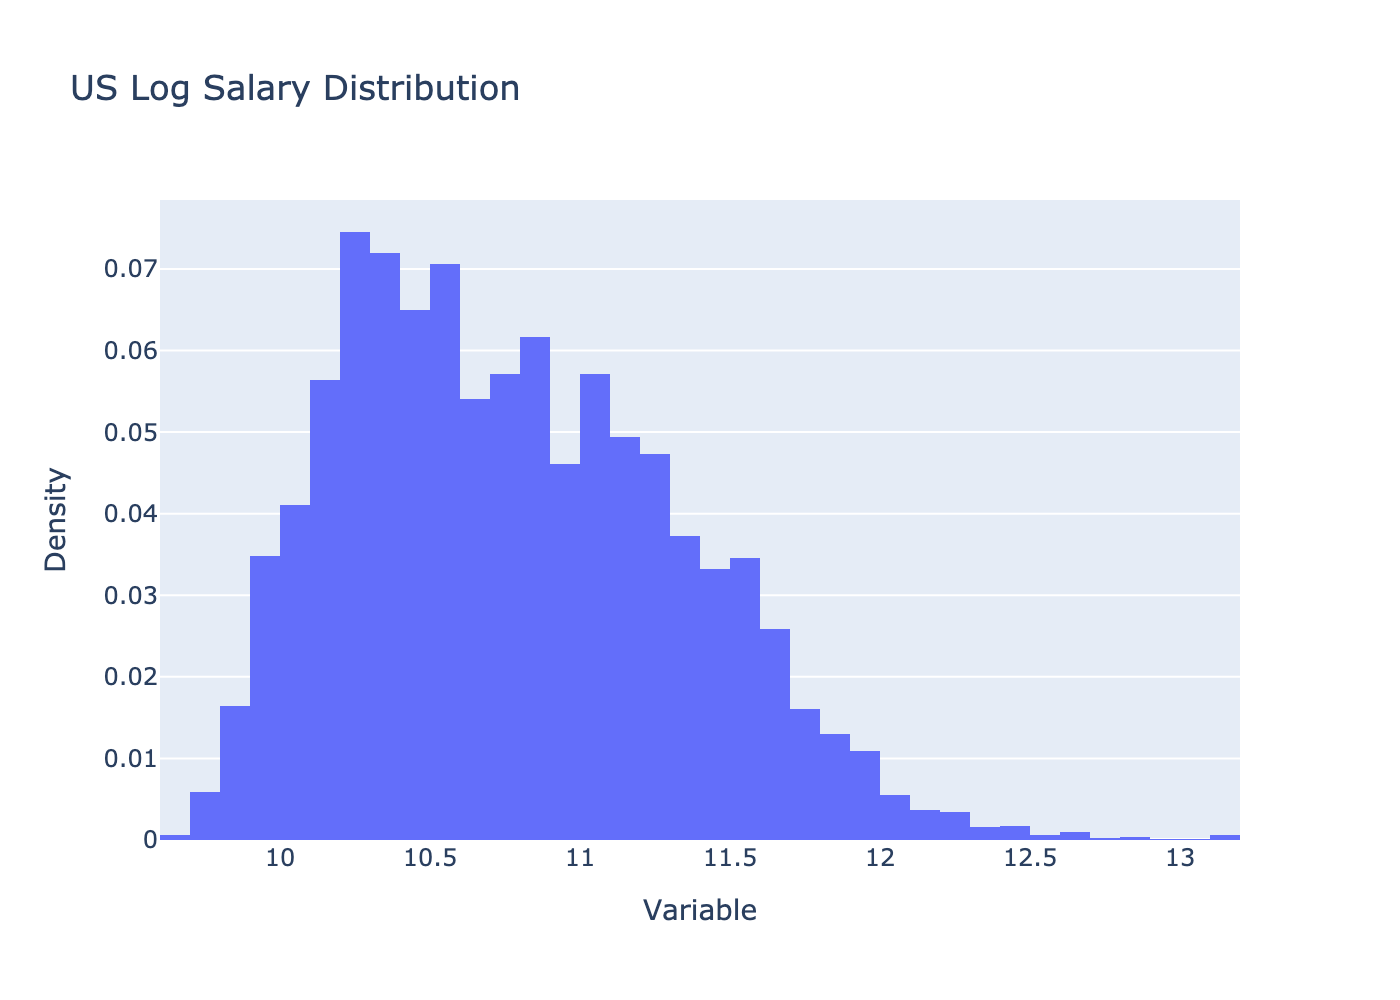

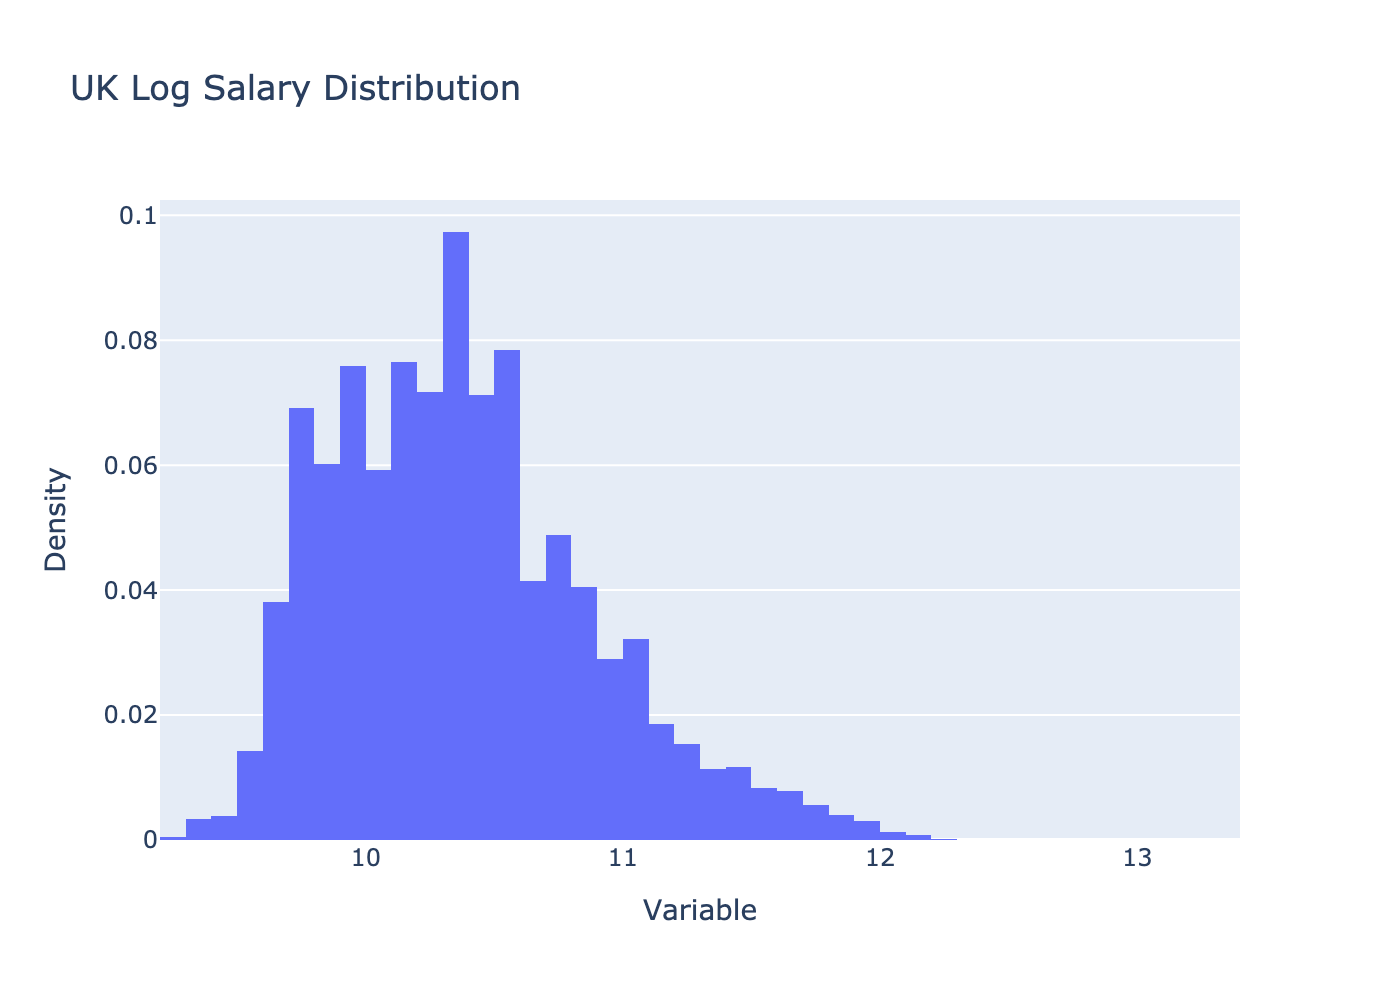

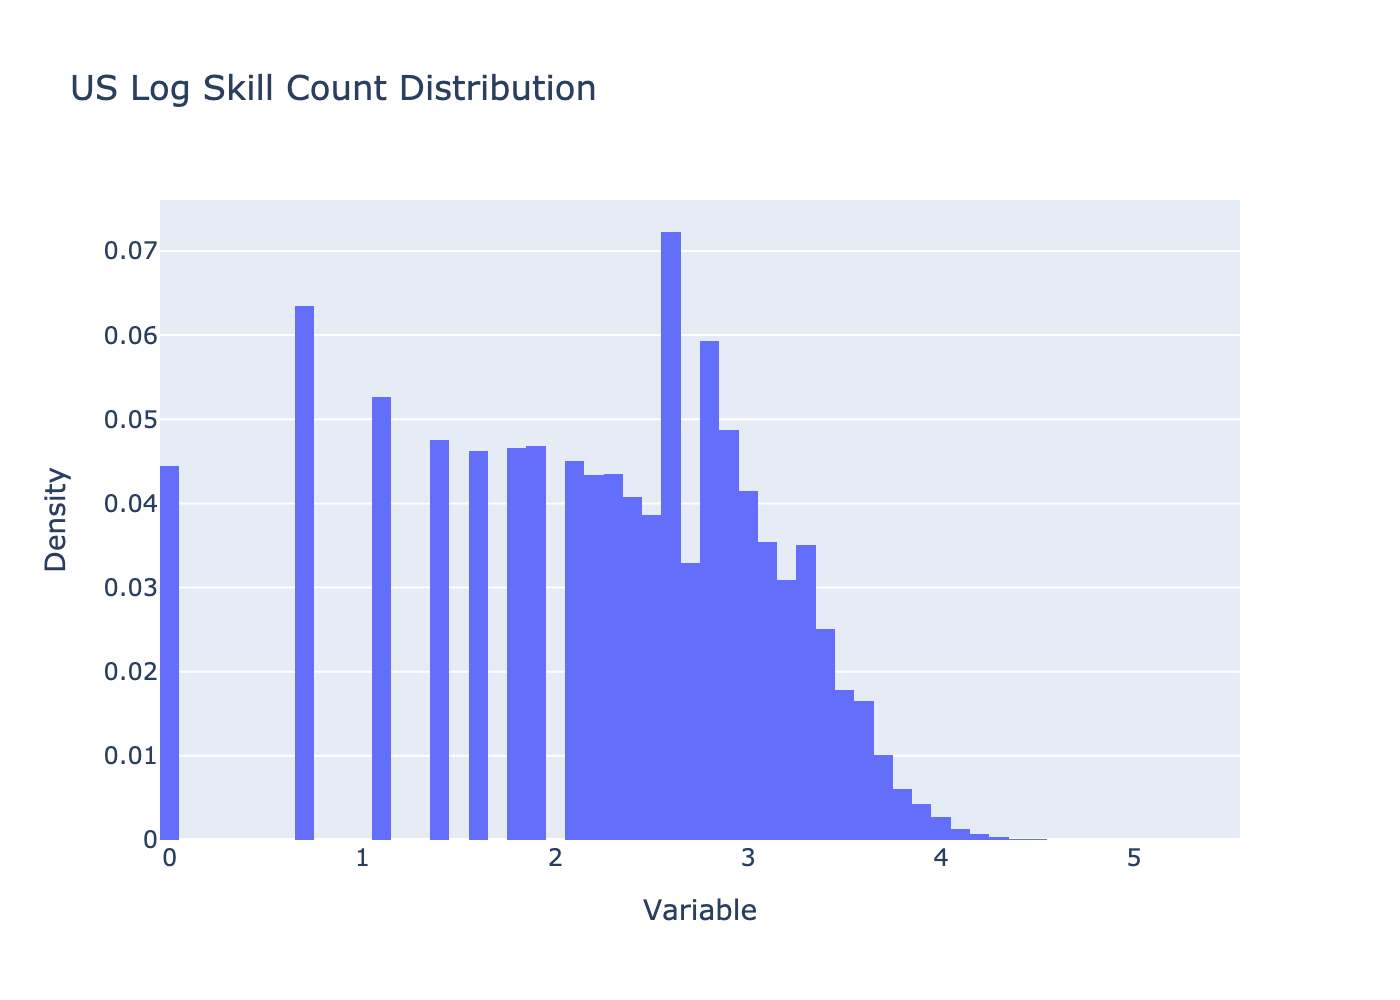

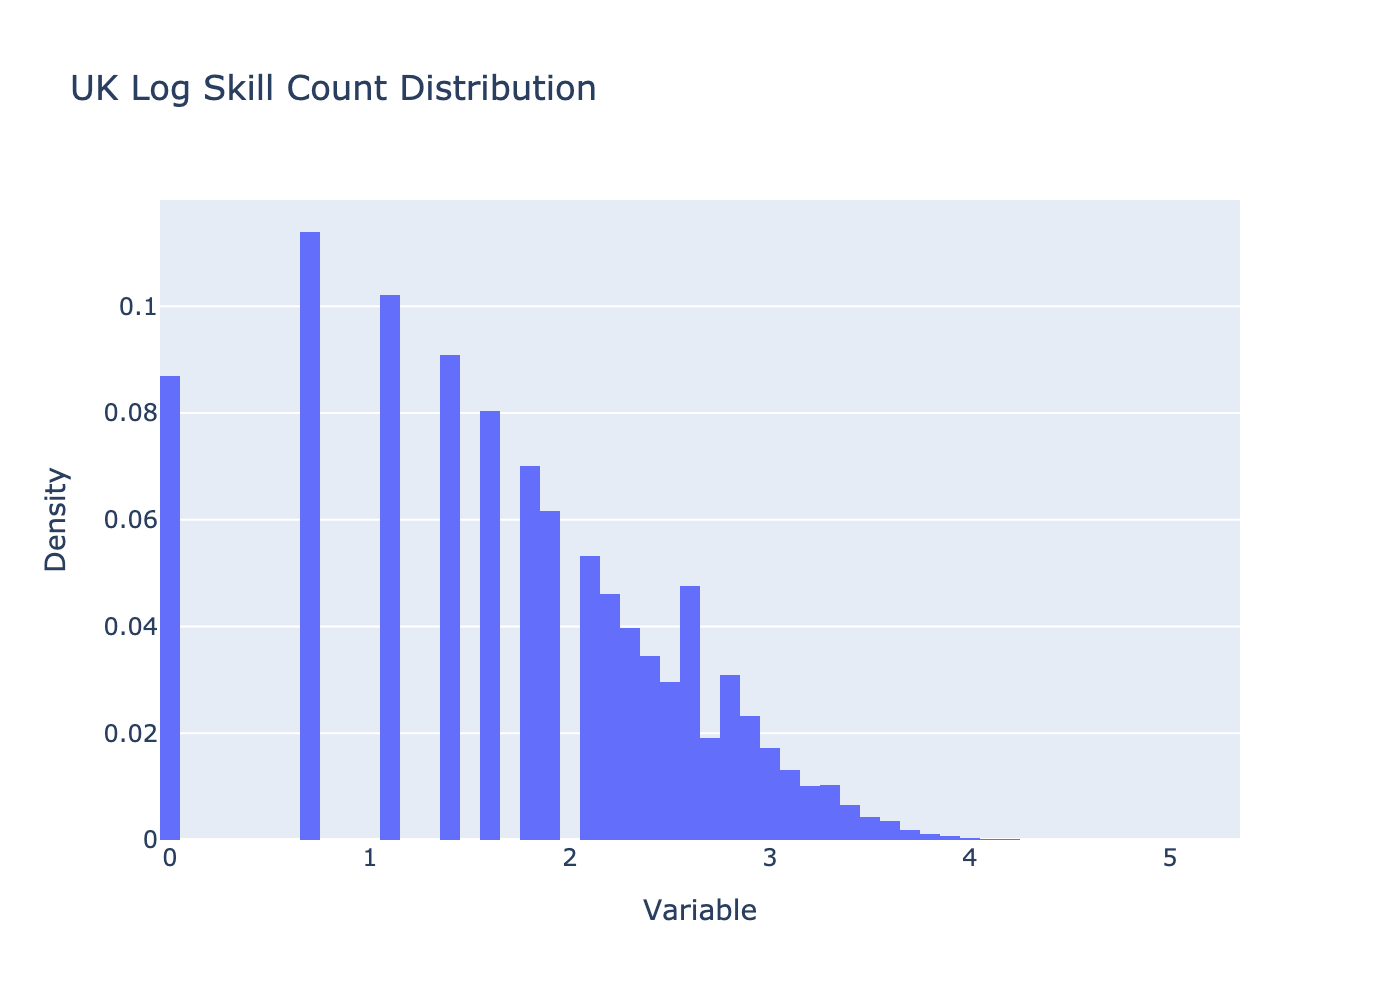

In [14]:
def display_dist(df, col, title, file_name):
    
    fig = go.Figure()
    fig.add_histogram(x=df[col], name="Variable", histnorm='probability', xbins=dict(size=0.1))
    fig.update_layout(title=title, xaxis_title="Variable", yaxis_title="Density", width=700, height=500)
    
    with open(f"figures/{file_name}.png", "wb") as f:
        f.write(fig.to_image(format="png", engine="kaleido", scale=2))
        
    display(IPImage(filename=f"figures/{file_name}.png", width=700, height=500))
    
display_dist(us_reg_df, "LOG_SALARY", "US Log Salary Distribution", "us-salary-dist")
display_dist(uk_reg_df, "LOG_SALARY", "UK Log Salary Distribution", "uk-salary-dist")
display_dist(us_reg_df, "LOG_SKILL_COUNT", "US Log Skill Count Distribution", "us-skill-count-dist")
display_dist(uk_reg_df, "LOG_SKILL_COUNT", "UK Log Skill Count Distribution", "uk-skill-count-dist")

# AI vs Degree Wage Premiums

In [15]:
us_edu_levels = ["No Education Listed", "High school or GED", "Associate degree", "Bachelor's degree", "Master's degree", "Ph.D. or professional degree"]
us_ols = smf.ols(formula="LOG_SALARY ~ AI_SKILL + MIN_YEARS_EXPERIENCE + C(MIN_EDULEVELS_NAME, levels=us_edu_levels) + YEAR + C(NAICS_2022_2_NAME) + C(SOC_2_NAME) + C(STATE)", data=us_reg_df).fit()
uk_edu_levels = ["No Education Listed", "A-levels or equivalent", "Up to GCSEs or equivalent", "Foundation/HNC/HND or equivalent", "Bachelor's or equivalent", "Master's or equivalent", "Ph.D. or equivalent"]
uk_ols = smf.ols(formula="LOG_SALARY ~ AI_SKILL + MIN_YEARS_EXPERIENCE + C(EDULEVELS_NAME_MIN, levels=uk_edu_levels) + YEAR + C(UK_SIC_1_NAME) + C(SOC_1_NAME) + C(NUTS1_NAME)", data=uk_reg_df).fit()

In [16]:
us_coefs = us_ols.summary2().tables[1]
us_r2 = us_ols.rsquared
us_coefs = us_coefs.loc[
    [
        "C(MIN_EDULEVELS_NAME, levels=us_edu_levels)[T.High school or GED]",
        "C(MIN_EDULEVELS_NAME, levels=us_edu_levels)[T.Associate degree]",
        "C(MIN_EDULEVELS_NAME, levels=us_edu_levels)[T.Bachelor's degree]",
        "C(MIN_EDULEVELS_NAME, levels=us_edu_levels)[T.Master's degree]",
        "C(MIN_EDULEVELS_NAME, levels=us_edu_levels)[T.Ph.D. or professional degree]",
        "AI_SKILL"
    ]
]
us_coefs.index = ["High School", "Associate", "Bachelor", "Master", "PhD", "AI Skill"]
us_coefs = us_coefs.reset_index().rename(columns={"index": "Variable", "Coef.": "Coefficient"})
print("US R2: ", us_r2)
display(us_coefs)

uk_coefs = uk_ols.summary2().tables[1]
uk_r2 = uk_ols.rsquared
uk_coefs = uk_coefs.loc[
    [
        "C(EDULEVELS_NAME_MIN, levels=uk_edu_levels)[T.Up to GCSEs or equivalent]",
        "C(EDULEVELS_NAME_MIN, levels=uk_edu_levels)[T.A-levels or equivalent]",
        "C(EDULEVELS_NAME_MIN, levels=uk_edu_levels)[T.Foundation/HNC/HND or equivalent]",
        "C(EDULEVELS_NAME_MIN, levels=uk_edu_levels)[T.Bachelor's or equivalent]",
        "C(EDULEVELS_NAME_MIN, levels=uk_edu_levels)[T.Master's or equivalent]",
        "C(EDULEVELS_NAME_MIN, levels=uk_edu_levels)[T.Ph.D. or equivalent]",
        "AI_SKILL"
    ]
]
uk_coefs.index = ["Up to GCSEs", "A-levels", "HNC/HND", "Bachelor", "Master", "PhD", "AI Skill"]
uk_coefs = uk_coefs.reset_index().rename(columns={"index": "Variable", "Coef.": "Coefficient"})
print("UK R2: ", uk_r2)
display(uk_coefs)

US R2:  0.497795072568305


,Variable,Coefficient,Std.Err.,t,P>|t|,[0.025,0.975]
0,High School,-0.229236,0.000963,-238.026884,0.000000e+00,-0.231123,-0.227348
1,Associate,-0.078005,0.001443,-54.060803,0.000000e+00,-0.080833,-0.075177
2,Bachelor,0.107400,0.000942,114.013252,0.000000e+00,0.105554,0.109246
3,Master,0.217114,0.002410,90.092067,0.000000e+00,0.212390,0.221837
4,PhD,0.355086,0.004103,86.550734,0.000000e+00,0.347045,0.363127
5,AI Skill,0.204628,0.005437,37.635491,8.590893e-310,0.193972,0.215285


UK R2:  0.3594563342485686


,Variable,Coefficient,Std.Err.,t,P>|t|,[0.025,0.975]
0,Up to GCSEs,-0.286936,0.001284,-223.515494,0.000000e+00,-0.289452,-0.284420
1,A-levels,-0.146784,0.001764,-83.191872,0.000000e+00,-0.150242,-0.143326
2,HNC/HND,0.042958,0.002129,20.174090,1.695160e-90,0.038785,0.047132
3,Bachelor,0.041065,0.000984,41.727761,0.000000e+00,0.039136,0.042994
4,Master,0.077164,0.003041,25.373072,5.319370e-142,0.071204,0.083125
5,PhD,0.307499,0.004305,71.427967,0.000000e+00,0.299061,0.315937
6,AI Skill,0.229367,0.004929,46.533160,0.000000e+00,0.219706,0.239028


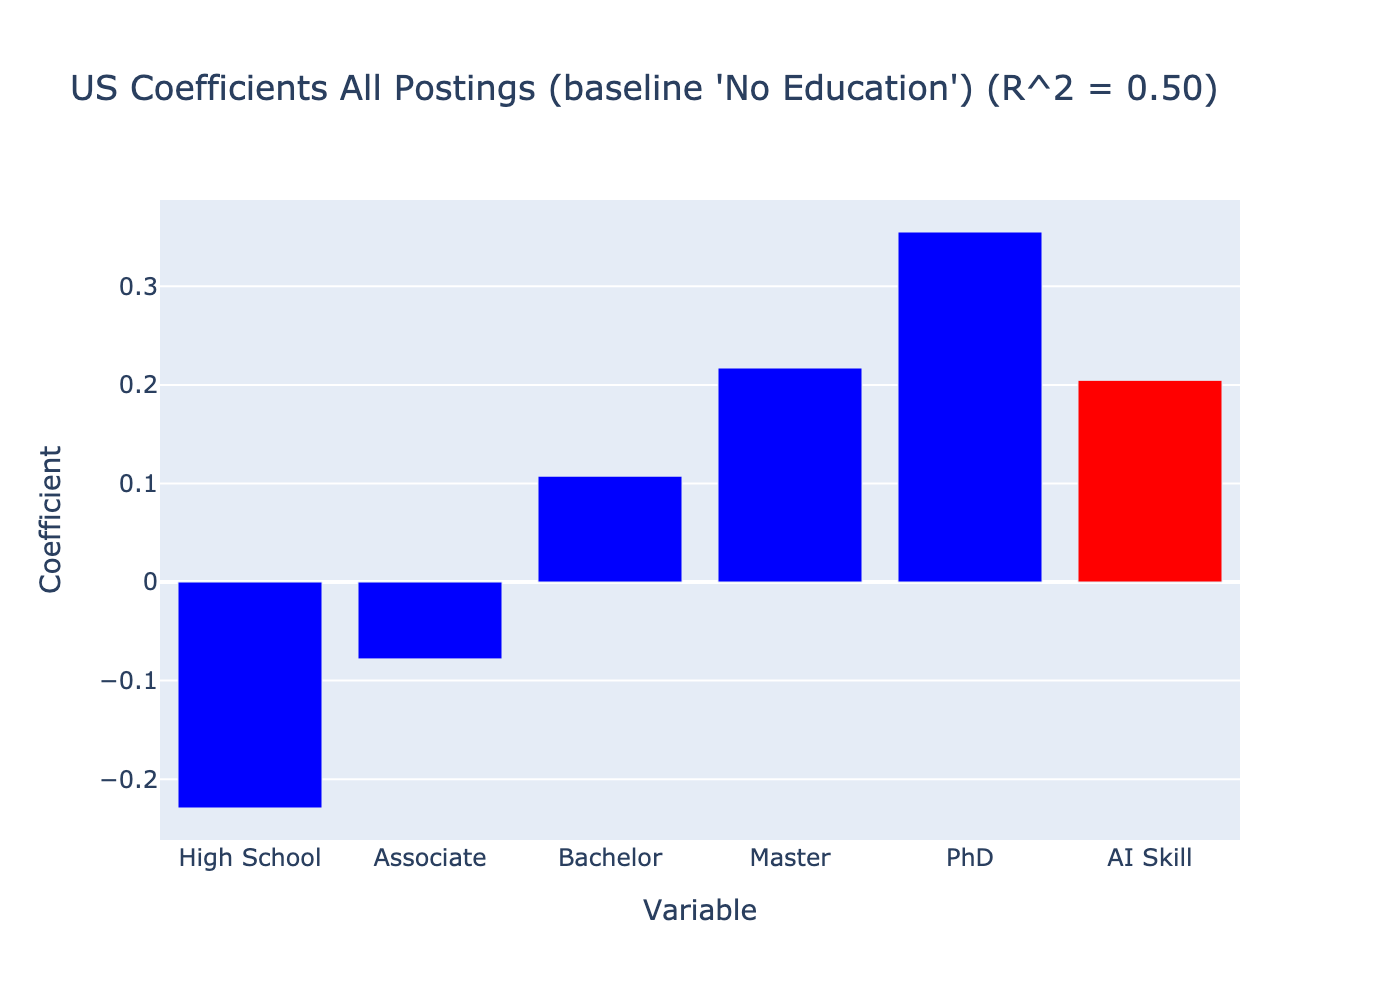

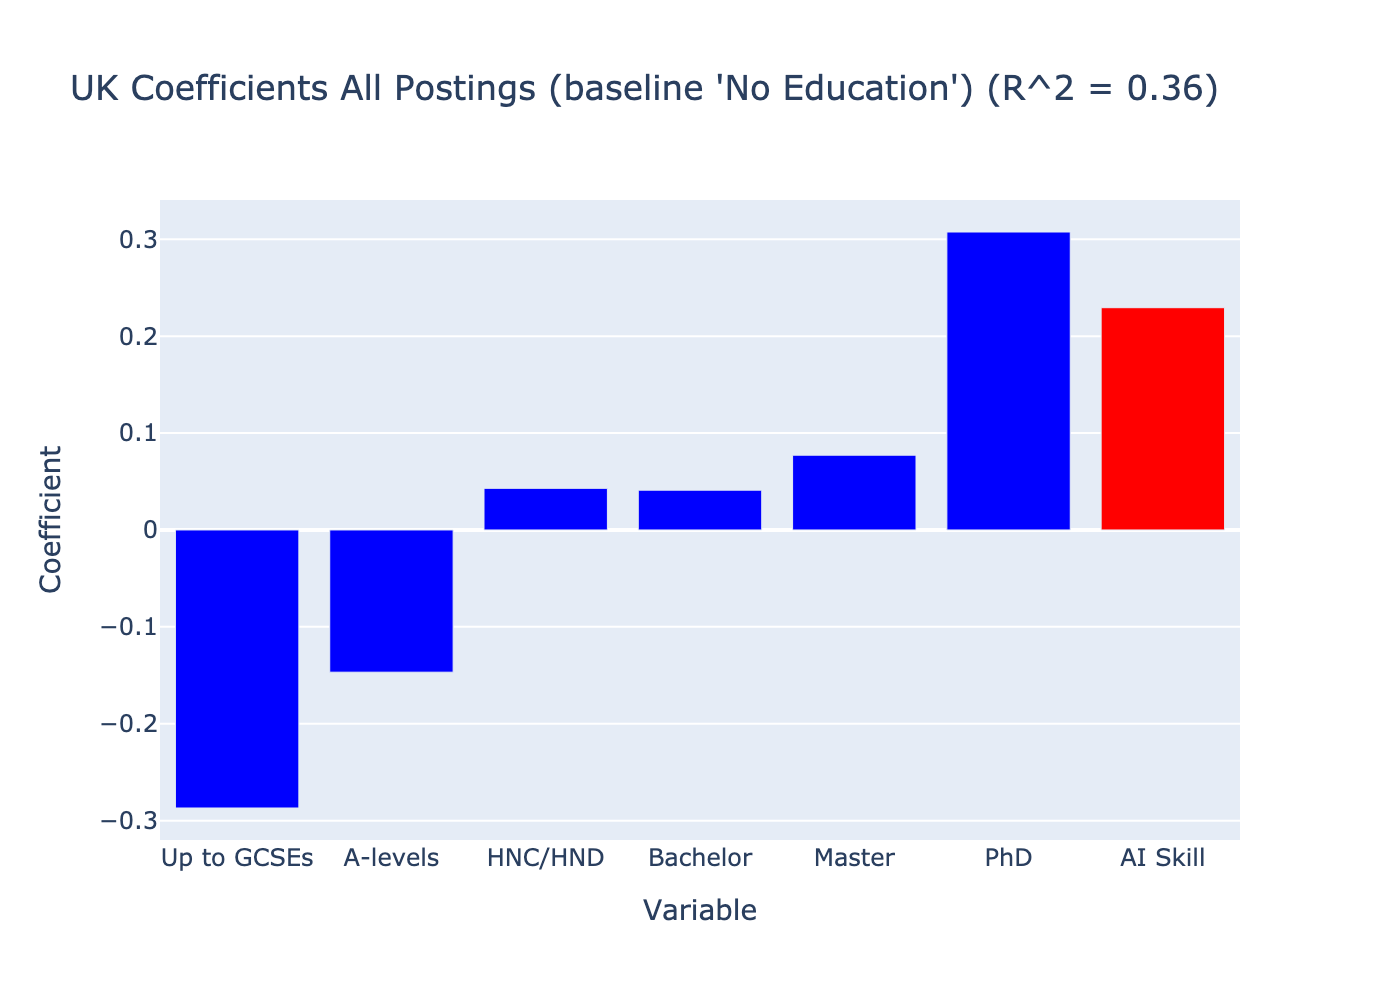

In [17]:
def display_coefficients(df, title, r2, file_name):
    # Initialize the figure
    fig = go.Figure()
    
    for i, (education_level, coefficient) in enumerate(zip(df["Variable"], df["Coefficient"])):
        color = "red" if i == len(df) - 1 else "blue"
        fig.add_trace(go.Bar(
            x=[education_level], 
            y=[coefficient], 
            name=education_level,
            marker_color=color
        ))

    fig.update_layout(
        title=title + f" (R^2 = {r2:.2f})", 
        xaxis_title="Variable", 
        yaxis_title="Coefficient", 
        width=700, 
        height=500,
        showlegend=False
    )

    
    with open(f"figures/{file_name}.png", "wb") as f:
        f.write(fig.to_image(format="png", engine="kaleido", scale=2))
        
    display(IPImage(filename=f"figures/{file_name}.png", width=700, height=500))
    
display_coefficients(us_coefs, "US Coefficients All Postings (baseline 'No Education')", us_r2, "us-coefficients")
display_coefficients(uk_coefs, "UK Coefficients All Postings (baseline 'No Education')", uk_r2, "uk-coefficients")

#### Interpretation

The regression here reveals a somewhat more subdued but still significant wage premium for AI skills. In the US, the AI premium is closer to a master's degree whereas in the UK it's just below a PhD. 

# Degree Premiums for AI vs non-AI jobs

In [18]:
us_ai_reg_df = us_ai_reg_df.to_pandas()
us_nonai_reg_df = us_nonai_reg_df.to_pandas()
uk_ai_reg_df = uk_ai_reg_df.to_pandas()
uk_nonai_reg_df = uk_nonai_reg_df.to_pandas()

us_ai_reg_df["LOG_SALARY"] = np.log(us_ai_reg_df["SALARY"])
us_nonai_reg_df["LOG_SALARY"] = np.log(us_nonai_reg_df["SALARY"])
uk_ai_reg_df["LOG_SALARY"] = np.log(uk_ai_reg_df["SALARY"])
uk_nonai_reg_df["LOG_SALARY"] = np.log(uk_nonai_reg_df["SALARY"])
us_ai_ols = smf.ols(formula="LOG_SALARY ~  SKILL_COUNT + MIN_YEARS_EXPERIENCE + C(MIN_EDULEVELS_NAME, levels=us_edu_levels) + YEAR + C(NAICS_2022_2_NAME) + C(SOC_2_NAME) + C(STATE)", data=us_ai_reg_df).fit()
us_nonai_ols = smf.ols(formula="LOG_SALARY ~ SKILL_COUNT + MIN_YEARS_EXPERIENCE + C(MIN_EDULEVELS_NAME, levels=us_edu_levels) + YEAR + C(NAICS_2022_2_NAME) + C(SOC_2_NAME) + C(STATE)", data=us_nonai_reg_df).fit()
uk_ai_ols = smf.ols(formula="LOG_SALARY ~ SKILL_COUNT + MIN_YEARS_EXPERIENCE + C(EDULEVELS_NAME_MIN, levels=uk_edu_levels) + YEAR + C(UK_SIC_1_NAME) + C(SOC_1_NAME) + C(NUTS1_NAME)", data=uk_ai_reg_df).fit()    
uk_nonai_ols = smf.ols(formula="LOG_SALARY ~ SKILL_COUNT + MIN_YEARS_EXPERIENCE + C(EDULEVELS_NAME_MIN, levels=uk_edu_levels) + YEAR + C(UK_SIC_1_NAME) + C(SOC_1_NAME) + C(NUTS1_NAME)", data=uk_nonai_reg_df).fit()

In [19]:
us_ai_coefs = us_ai_ols.summary2().tables[1]
us_ai_r2 = us_ai_ols.rsquared
us_ai_coefs = us_ai_coefs.loc[
    [
        "C(MIN_EDULEVELS_NAME, levels=us_edu_levels)[T.High school or GED]",
        "C(MIN_EDULEVELS_NAME, levels=us_edu_levels)[T.Associate degree]",
        "C(MIN_EDULEVELS_NAME, levels=us_edu_levels)[T.Bachelor's degree]",
        "C(MIN_EDULEVELS_NAME, levels=us_edu_levels)[T.Master's degree]",
        "C(MIN_EDULEVELS_NAME, levels=us_edu_levels)[T.Ph.D. or professional degree]",
        "SKILL_COUNT"
    ]
]
us_ai_coefs.index = ["High School", "Associate", "Bachelor", "Master", "PhD", "Skill Count"]
us_ai_coefs = us_ai_coefs.reset_index().rename(columns={"index": "Education Level", "Coef.": "Coefficient"})
print("US AI R2: ", us_ai_r2)
display(us_ai_coefs)

us_nonai_coefs = us_nonai_ols.summary2().tables[1]
us_nonai_r2 = us_nonai_ols.rsquared
us_nonai_coefs = us_nonai_coefs.loc[
    [
        "C(MIN_EDULEVELS_NAME, levels=us_edu_levels)[T.High school or GED]",
        "C(MIN_EDULEVELS_NAME, levels=us_edu_levels)[T.Associate degree]",
        "C(MIN_EDULEVELS_NAME, levels=us_edu_levels)[T.Bachelor's degree]",
        "C(MIN_EDULEVELS_NAME, levels=us_edu_levels)[T.Master's degree]",
        "C(MIN_EDULEVELS_NAME, levels=us_edu_levels)[T.Ph.D. or professional degree]",
        "SKILL_COUNT"
    ]
]
us_nonai_coefs.index = ["High School", "Associate", "Bachelor", "Master", "PhD", "Skill Count"]
us_nonai_coefs = us_nonai_coefs.reset_index().rename(columns={"index": "Education Level", "Coef.": "Coefficient"})
print("US Non-AI R2: ", us_nonai_r2)
display(us_nonai_coefs)

uk_ai_coefs = uk_ai_ols.summary2().tables[1]
uk_ai_r2 = uk_ai_ols.rsquared
uk_ai_coefs = uk_ai_coefs.loc[
    [
        "C(EDULEVELS_NAME_MIN, levels=uk_edu_levels)[T.Up to GCSEs or equivalent]",
        "C(EDULEVELS_NAME_MIN, levels=uk_edu_levels)[T.A-levels or equivalent]",
        "C(EDULEVELS_NAME_MIN, levels=uk_edu_levels)[T.Foundation/HNC/HND or equivalent]",
        "C(EDULEVELS_NAME_MIN, levels=uk_edu_levels)[T.Bachelor's or equivalent]",
        "C(EDULEVELS_NAME_MIN, levels=uk_edu_levels)[T.Master's or equivalent]",
        "C(EDULEVELS_NAME_MIN, levels=uk_edu_levels)[T.Ph.D. or equivalent]",
        "SKILL_COUNT"
    ]
]
uk_ai_coefs.index = ["Up to GCSEs", "A-levels", "HNC/HND", "Bachelor", "Master", "PhD", "Skill Count"]
uk_ai_coefs = uk_ai_coefs.reset_index().rename(columns={"index": "Education Level", "Coef.": "Coefficient"})
print("UK AI R2: ", uk_ai_r2)
display(uk_ai_coefs)

uk_nonai_coefs = uk_nonai_ols.summary2().tables[1]
uk_nonai_r2 = uk_nonai_ols.rsquared
uk_nonai_coefs = uk_nonai_coefs.loc[
    [
        "C(EDULEVELS_NAME_MIN, levels=uk_edu_levels)[T.Up to GCSEs or equivalent]",
        "C(EDULEVELS_NAME_MIN, levels=uk_edu_levels)[T.A-levels or equivalent]",
        "C(EDULEVELS_NAME_MIN, levels=uk_edu_levels)[T.Foundation/HNC/HND or equivalent]",
        "C(EDULEVELS_NAME_MIN, levels=uk_edu_levels)[T.Bachelor's or equivalent]",
        "C(EDULEVELS_NAME_MIN, levels=uk_edu_levels)[T.Master's or equivalent]",
        "C(EDULEVELS_NAME_MIN, levels=uk_edu_levels)[T.Ph.D. or equivalent]",
        "SKILL_COUNT"
    ]
]
uk_nonai_coefs.index = ["Up to GCSEs", "A-levels", "HNC/HND", "Bachelor", "Master", "PhD", "Skill Count"]
uk_nonai_coefs = uk_nonai_coefs.reset_index().rename(columns={"index": "Education Level", "Coef.": "Coefficient"})
print("UK Non-AI R2: ", uk_nonai_r2)
display(uk_nonai_coefs)


US AI R2:  0.4825114897070427


,Education Level,Coefficient,Std.Err.,t,P>|t|,[0.025,0.975]
0,High School,-0.266858,0.025084,-10.638567,3.881506e-26,-0.316034,-0.217681
1,Associate,-0.186808,0.027955,-6.682434,2.621420e-11,-0.241613,-0.132003
2,Bachelor,-0.001672,0.011685,-0.143051,8.862556e-01,-0.024580,0.021236
3,Master,0.082339,0.017759,4.636320,3.642093e-06,0.047522,0.117155
4,PhD,0.079987,0.029903,2.674907,7.500702e-03,0.021364,0.138610
5,Skill Count,-0.000192,0.000383,-0.501574,6.159907e-01,-0.000943,0.000559


US Non-AI R2:  0.49803130858800215


,Education Level,Coefficient,Std.Err.,t,P>|t|,[0.025,0.975]
0,High School,-0.240312,0.000972,-247.256271,0.0,-0.242217,-0.238407
1,Associate,-0.093930,0.001456,-64.526774,0.0,-0.096783,-0.091077
2,Bachelor,0.088803,0.000973,91.277439,0.0,0.086896,0.090709
3,Master,0.202517,0.002432,83.277574,0.0,0.197751,0.207283
4,PhD,0.347995,0.004126,84.334621,0.0,0.339908,0.356083
5,Skill Count,0.003152,0.000040,79.162903,0.0,0.003074,0.003230


UK AI R2:  0.37621486063106047


,Education Level,Coefficient,Std.Err.,t,P>|t|,[0.025,0.975]
0,Up to GCSEs,-0.647572,0.041918,-15.448488,6.496362e-53,-0.729745,-0.565399
1,A-levels,-0.257777,0.038520,-6.692054,2.381885e-11,-0.333289,-0.182266
2,HNC/HND,-0.031261,0.055493,-0.563338,5.732242e-01,-0.140046,0.077523
3,Bachelor,-0.096636,0.012265,-7.878689,3.843936e-15,-0.120680,-0.072592
4,Master,-0.007431,0.018594,-0.399647,6.894297e-01,-0.043881,0.029019
5,PhD,0.093644,0.019535,4.793576,1.674308e-06,0.055348,0.131939
6,Skill Count,0.005922,0.000464,12.772413,6.395442e-37,0.005013,0.006831


UK Non-AI R2:  0.3670162021695037


,Education Level,Coefficient,Std.Err.,t,P>|t|,[0.025,0.975]
0,Up to GCSEs,-0.298845,0.001277,-233.974632,0.000000e+00,-0.301349,-0.296342
1,A-levels,-0.143955,0.001753,-82.113416,0.000000e+00,-0.147391,-0.140519
2,HNC/HND,0.032356,0.002116,15.289966,8.993199e-53,0.028209,0.036504
3,Bachelor,0.024108,0.000987,24.432268,8.192854e-132,0.022174,0.026042
4,Master,0.056859,0.003066,18.547755,8.655187e-77,0.050851,0.062867
5,PhD,0.310989,0.004394,70.773469,0.000000e+00,0.302376,0.319601
6,Skill Count,0.006806,0.000044,155.375188,0.000000e+00,0.006720,0.006892


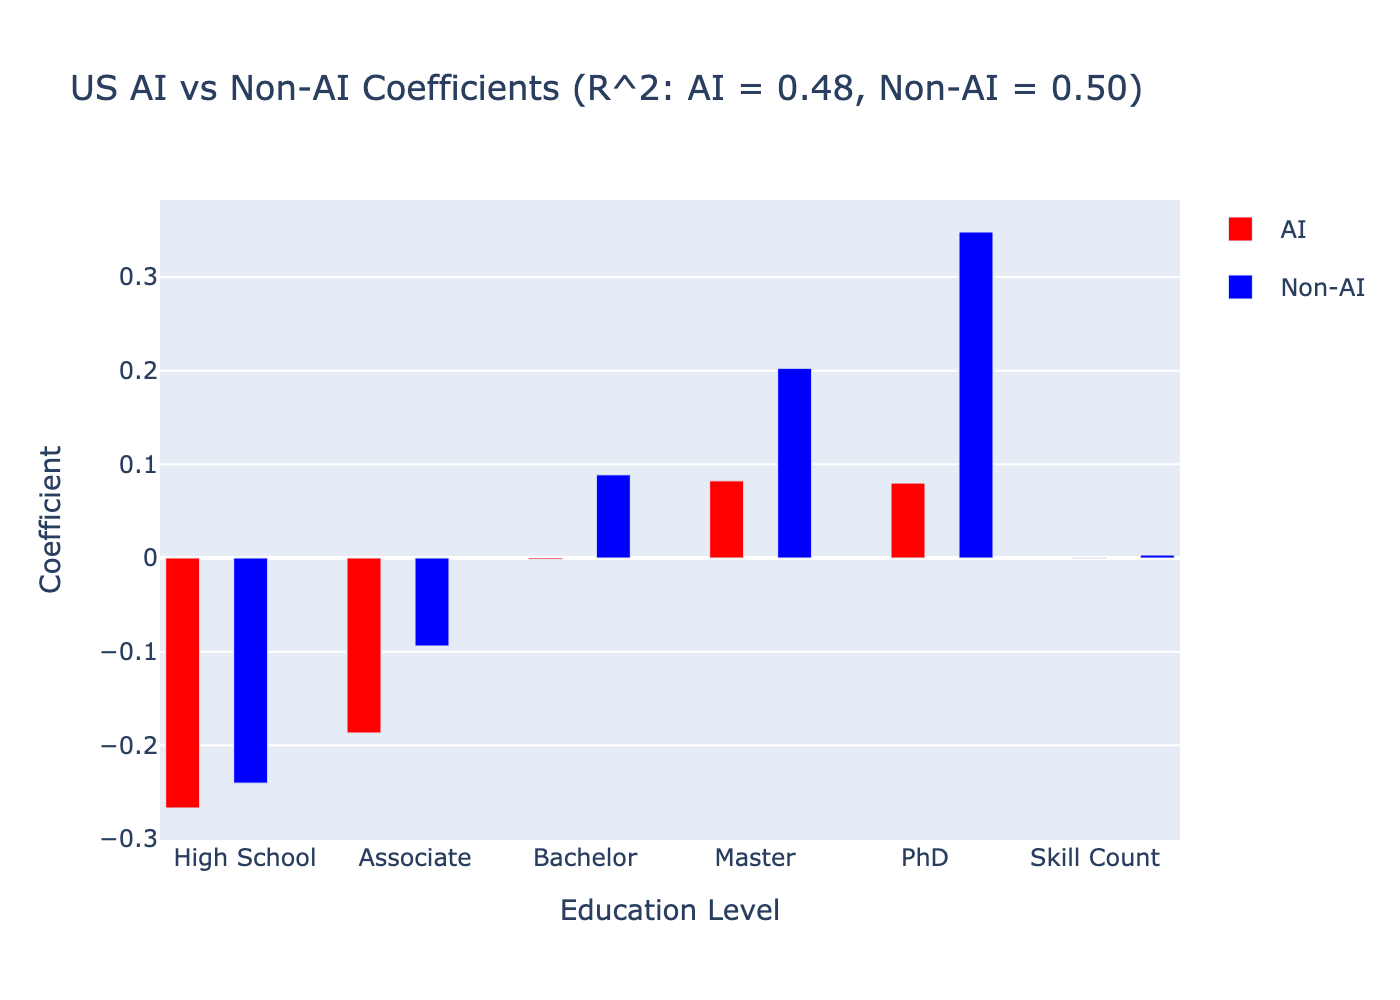

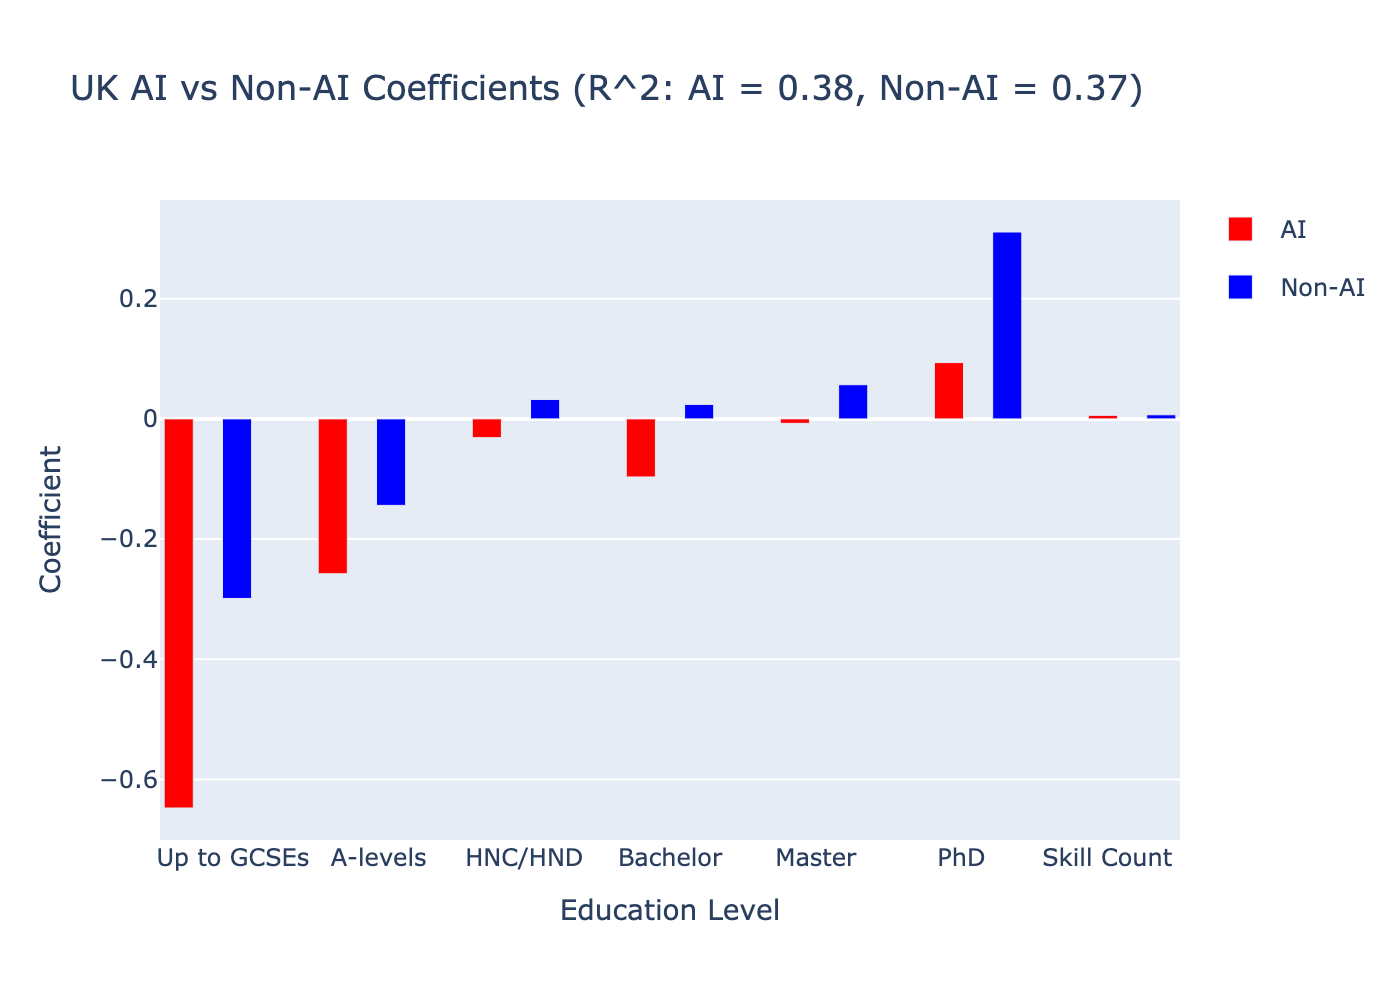

In [20]:
def display_ai_nonai_edu_coefs(ai_coefs, nonai_coefs, ai_r2, nonai_r2, title, file_name):
    
    fig = go.Figure()
    
    for i, (df, name) in enumerate(zip([ai_coefs, nonai_coefs], ["AI", "Non-AI"])):
        for education_level, coefficient in zip(df["Education Level"], df["Coefficient"]):
            color = "red" if i == 0 else "blue"
            fig.add_trace(go.Bar(
                x=[education_level], 
                y=[coefficient], 
                name=name,
                legendgroup=name,
                showlegend=(education_level == df["Education Level"].iloc[0]), 
                marker_color=color,
                width=.2
            ))

    fig.update_layout(
        title=title + f" (R^2: AI = {ai_r2:.2f}, Non-AI = {nonai_r2:.2f})",
        xaxis_title="Education Level", 
        yaxis_title="Coefficient", 
        width=700, 
        height=500,
        barmode='group'
    )

    
    with open(f"figures/{file_name}.png", "wb") as f:
        f.write(fig.to_image(format="png", engine="kaleido", scale=2))
        
    display(IPImage(filename=f"figures/{file_name}.png", width=700, height=500))

display_ai_nonai_edu_coefs(us_ai_coefs, us_nonai_coefs, us_ai_r2, us_nonai_r2, "US AI vs Non-AI Coefficients", "us-ai-nonai-coefficients")
display_ai_nonai_edu_coefs(uk_ai_coefs, uk_nonai_coefs, uk_ai_r2, uk_nonai_r2, "UK AI vs Non-AI Coefficients", "uk-ai-nonai-coefficients")

#### Interpretation

Here we can see for both the US and UK, the wage premiums of degrees are significantly lower for AI jobs though it looks like this isn't clear for master's degrees in the UK (coefficients are relative to posts that dont' require a degree). Interestingly, there's a more negative impact of lower-degree requirements on wages for AI jobs. This may be due to AI-related jobs that don't require much education are typically very low paying jobs like labeling. 

# Yearly AI Wage Premium

In [21]:
year_levels = [year for year in range(2014, 2020)]

def us_deg_ols(df):
    return smf.ols(formula="LOG_SALARY ~ AI_SKILL +  MIN_YEARS_EXPERIENCE + C(MIN_EDULEVELS_NAME, levels=us_edu_levels) + C(NAICS_2022_2_NAME) + C(SOC_2_NAME) + C(STATE)", data=df).fit()

def uk_deg_ols(df):
    return smf.ols(formula="LOG_SALARY ~ AI_SKILL +  MIN_YEARS_EXPERIENCE + C(EDULEVELS_NAME_MIN, levels=uk_edu_levels) + C(UK_SIC_1_NAME) + C(SOC_1_NAME) + C(NUTS1_NAME)", data=df).fit()

yearly_us_deg_ols = [us_deg_ols(us_reg_df[us_reg_df["YEAR"] == year]) for year in year_levels]
yearly_uk_deg_ols = [uk_deg_ols(uk_reg_df[uk_reg_df["YEAR"] == year]) for year in year_levels]

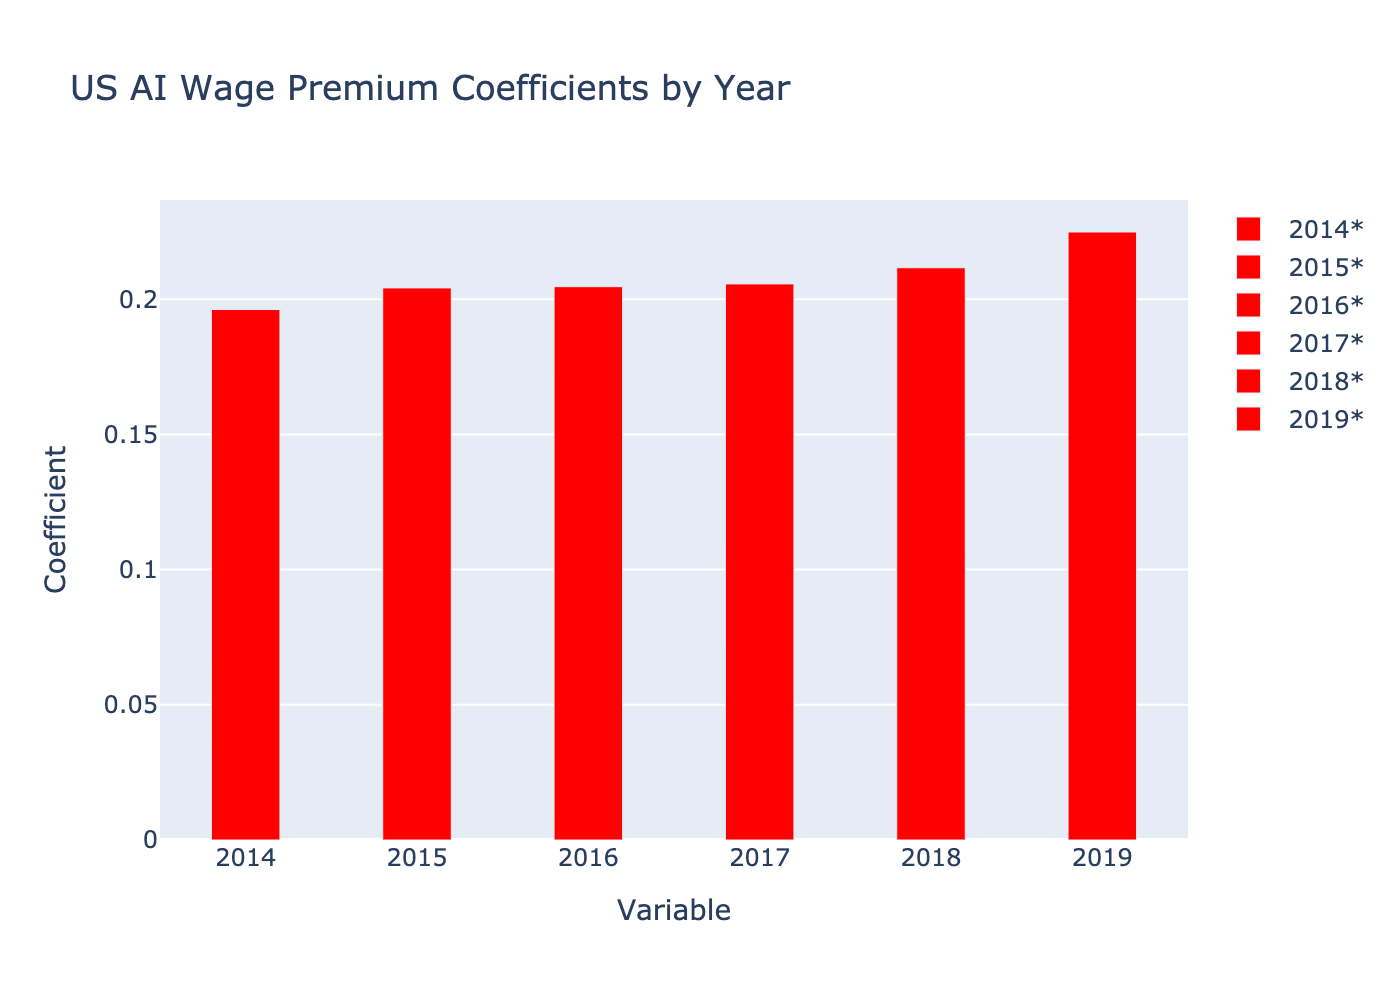

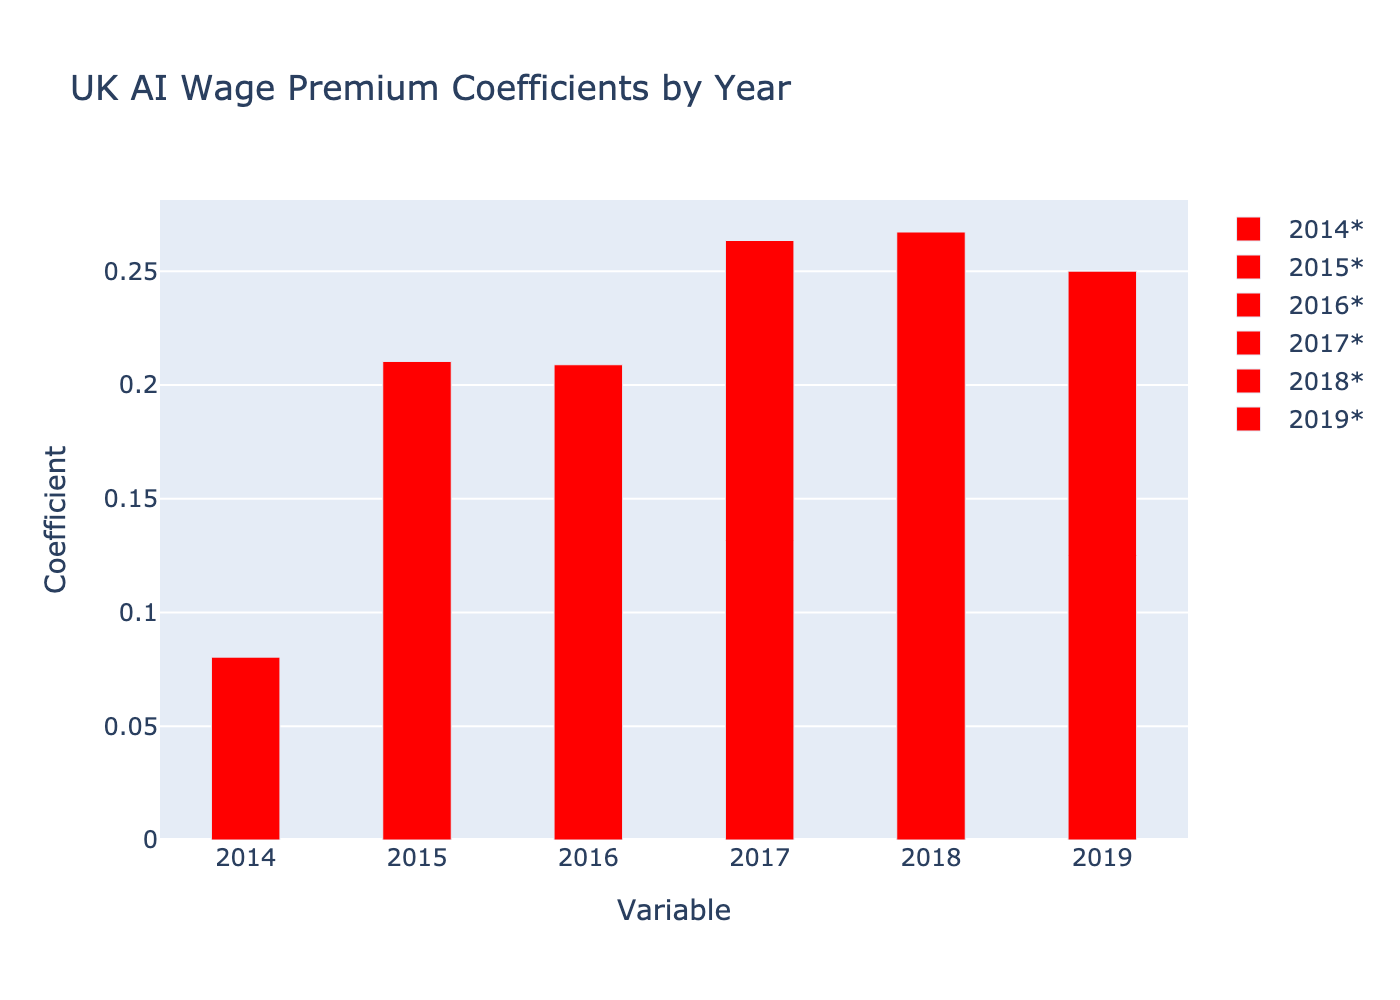

In [22]:
def display_yearly_ai_coefs(yearly_ols, title, file_name):
    
    fig = go.Figure()
    
    for i, ols in enumerate(yearly_ols):
        coefs = ols.summary2().tables[1]
        coef = coefs.loc["AI_SKILL", "Coef."]
        signif = "*" if coefs.loc["AI_SKILL", "P>|t|"] < 0.05 else ""
        fig.add_trace(go.Bar(
            x=[year_levels[i]], 
            y=[coef], 
            name=f"{year_levels[i]}{signif}",
            marker_color="red",
            width=.4
        ))
        
    fig.update_layout(
        title=title,
        xaxis_title="Variable", 
        yaxis_title="Coefficient", 
        width=700, 
        height=500
    )
    
    with open(f"figures/{file_name}.png", "wb") as f:
        f.write(fig.to_image(format="png", engine="kaleido", scale=2))
        
    display(IPImage(filename=f"figures/{file_name}.png", width=700, height=500))
    
display_yearly_ai_coefs(yearly_us_deg_ols, "US AI Wage Premium Coefficients by Year", "us-ai-coefficients-yearly")
display_yearly_ai_coefs(yearly_uk_deg_ols, "UK AI Wage Premium Coefficients by Year", "uk-ai-coefficients-yearly")

#### Interpretation

We can see that both for the US and UK, there is a steady increase in the AI wage premium. However, the increase is much more dramtic for the UK than for the US over this period. 

# AI Degree Requirements

In [24]:
us_reg_df["DEGREE"] = us_reg_df["DEGREE"].astype(int)
us_reg_df["POSTGRAD_DEGREE"] = us_reg_df["POSTGRAD_DEGREE"].astype(int)
uk_reg_df["DEGREE"] = uk_reg_df["DEGREE"].astype(int)
uk_reg_df["POSTGRAD_DEGREE"] = uk_reg_df["POSTGRAD_DEGREE"].astype(int)

def us_deg_ols(df):
    return smf.logit(formula="DEGREE ~ AI_SKILL + MIN_YEARS_EXPERIENCE + C(NAICS_2022_2_NAME) + C(SOC_2_NAME) + C(STATE)", data=df).fit()

def us_postgrad_deg_ols(df):
    return smf.logit(formula="POSTGRAD_DEGREE ~ AI_SKILL + MIN_YEARS_EXPERIENCE + C(NAICS_2022_2_NAME) + C(SOC_2_NAME) + C(STATE)", data=df).fit()

def uk_deg_ols(df):
    return smf.logit(formula="DEGREE ~ AI_SKILL + MIN_YEARS_EXPERIENCE + C(UK_SIC_1_NAME) + C(SOC_1_NAME) + C(NUTS1_NAME)", data=df).fit()

def uk_postgrad_deg_ols(df):
    # removed MIN_YEARS_EXPERIENCE
    return smf.logit(formula="POSTGRAD_DEGREE ~ AI_SKILL + C(UK_SIC_1_NAME) + C(SOC_1_NAME) + C(NUTS1_NAME)", data=df).fit()

yearly_us_deg_ols = [us_deg_ols(us_reg_df[us_reg_df["YEAR"] == year]) for year in year_levels]
yearly_us_postgrad_deg_ols = [us_postgrad_deg_ols(us_reg_df[us_reg_df["YEAR"] == year]) for year in year_levels]
yearly_uk_deg_ols = [uk_deg_ols(uk_reg_df[uk_reg_df["YEAR"] == year]) for year in year_levels]
yearly_uk_postgrad_deg_ols = [uk_postgrad_deg_ols(uk_reg_df[uk_reg_df["YEAR"] == year]) for year in year_levels]

Optimization terminated successfully.
         Current function value: 0.080865
         Iterations 11
         Current function value: 0.067142
         Iterations: 35


/Users/matthewbone/Documents/Coding/VSCode/skills-based-hiring/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Optimization terminated successfully.
         Current function value: 0.065958
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.069226
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.069914
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.078342
         Iterations 10


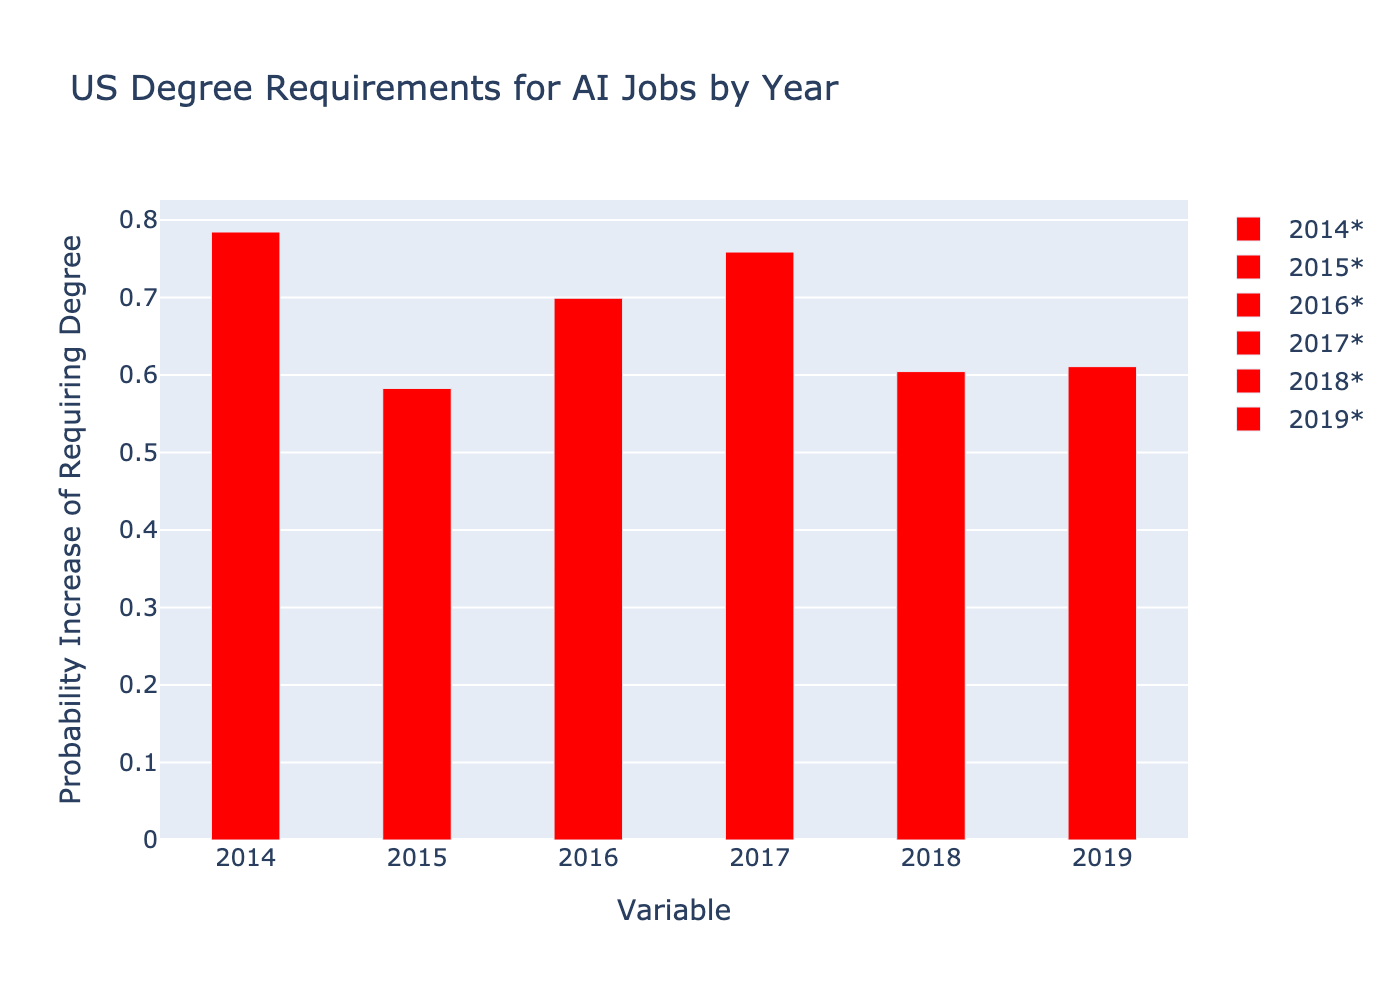

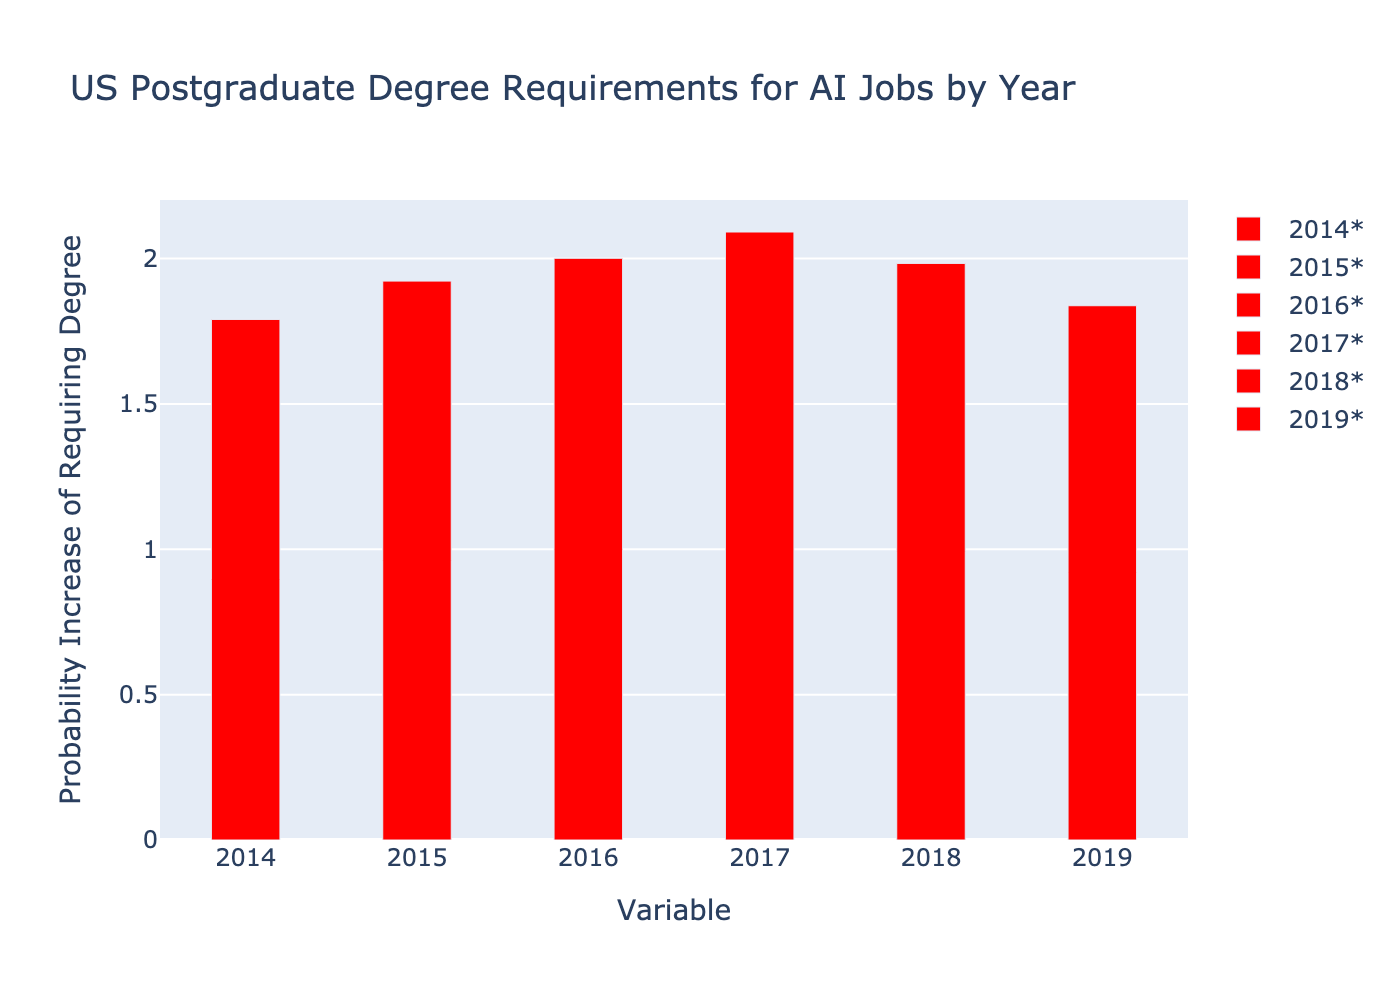

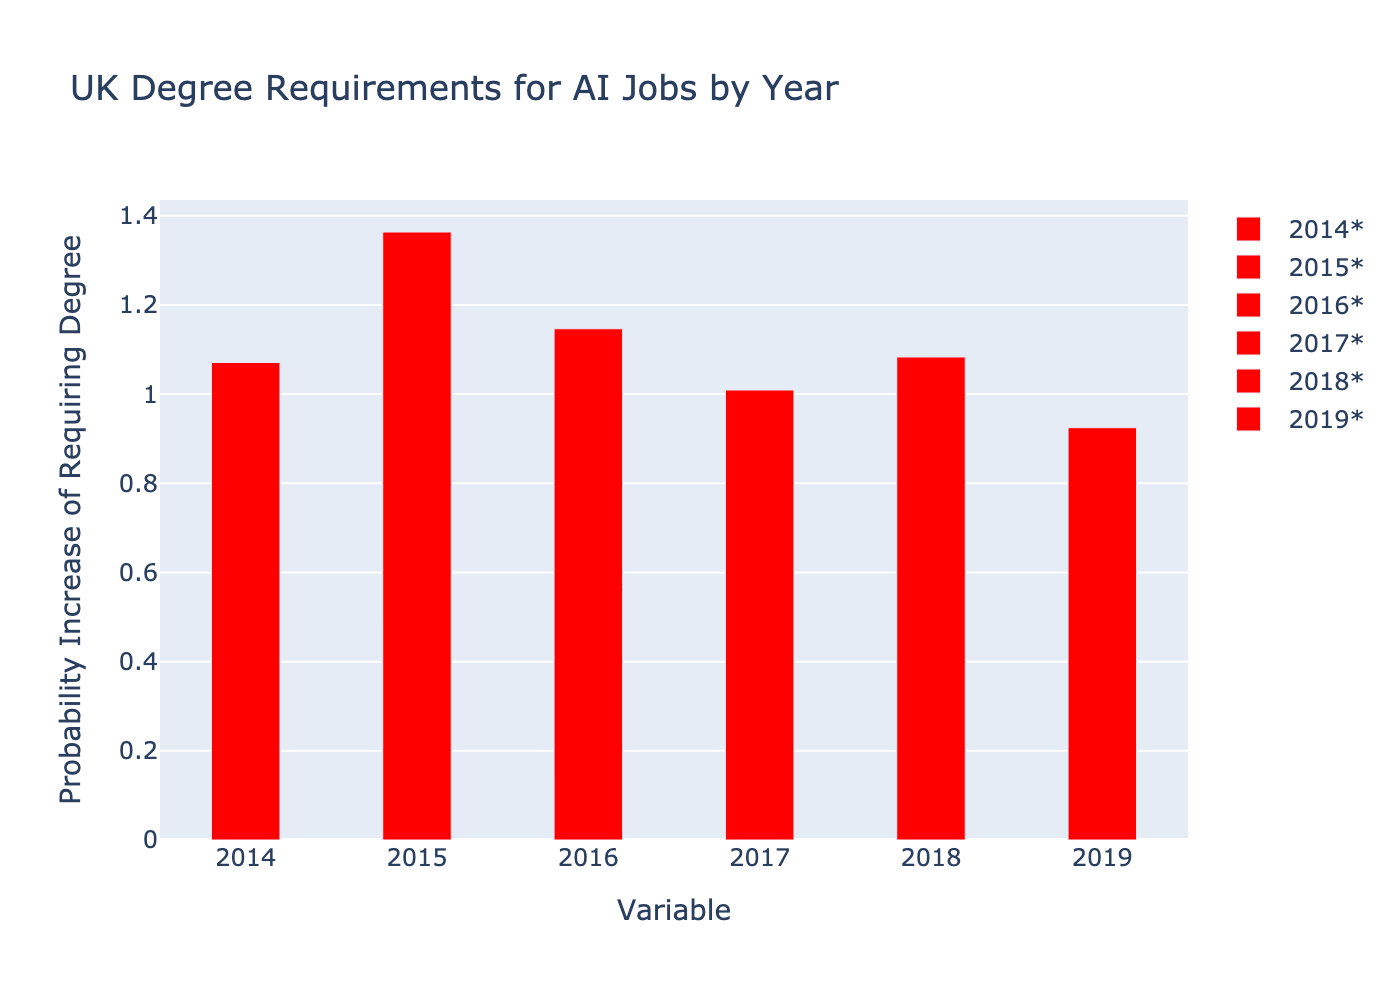

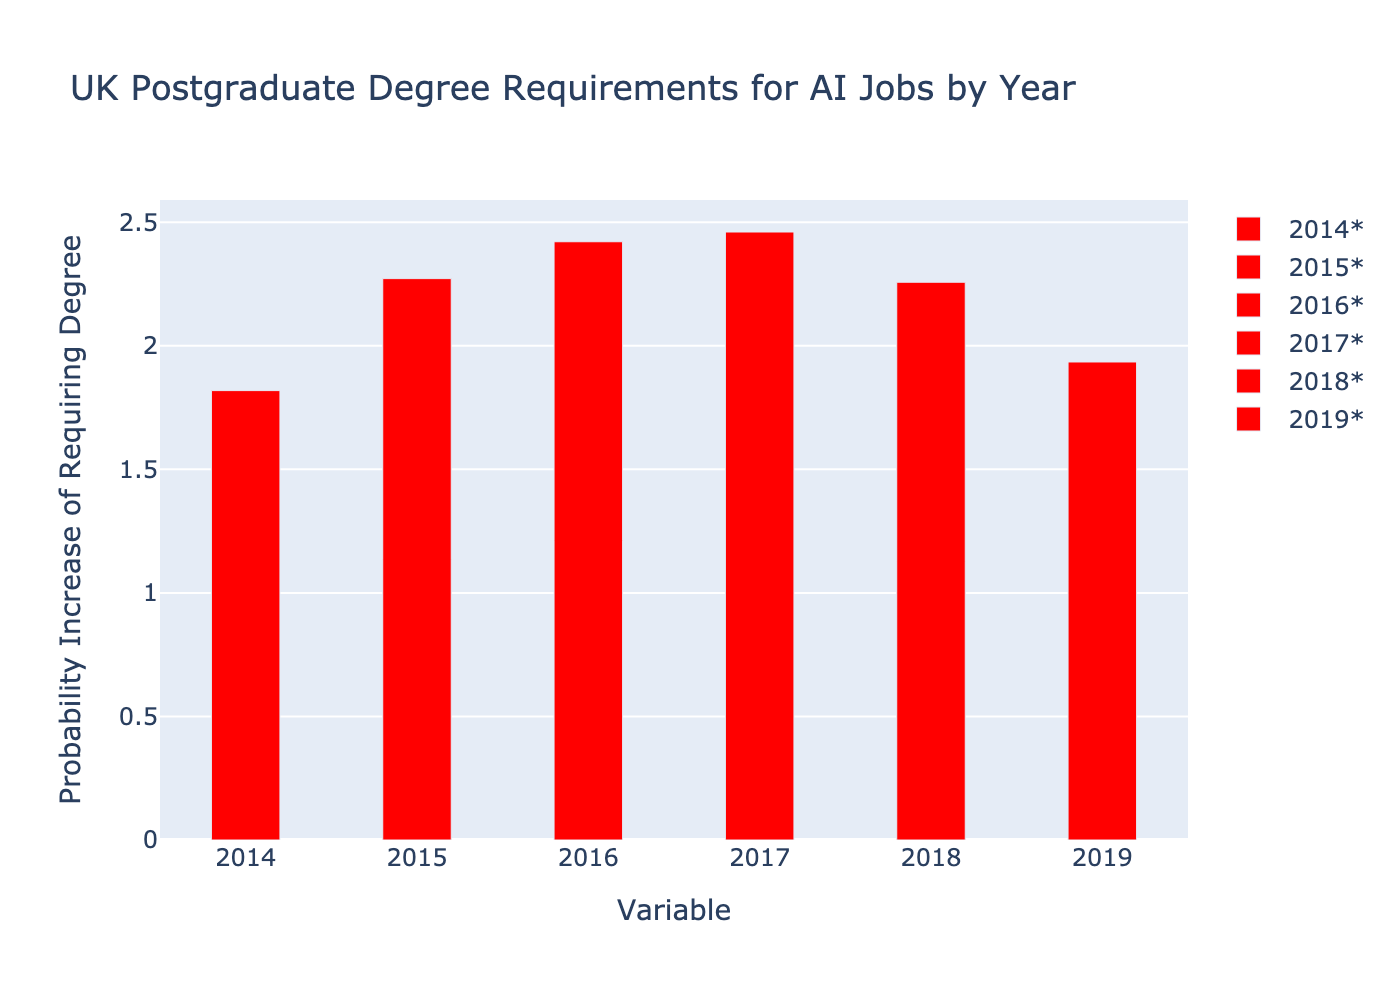

In [26]:
def display_yearly_deg_coefs(yearly_ols, title, file_name):
    
    fig = go.Figure()
    
    for i, ols in enumerate(yearly_ols):
        coefs = ols.summary2().tables[1]
        coef = coefs.loc["AI_SKILL", "Coef."]
        signif = "*" if coefs.loc["AI_SKILL", "P>|z|"] < 0.05 else ""
        fig.add_trace(go.Bar(
            x=[year_levels[i]], 
            y=[coef], 
            name=f"{year_levels[i]}{signif}",
            marker_color="red",
            width=.4
        ))
        
    fig.update_layout(
        title=title,
        xaxis_title="Variable", 
        yaxis_title="Probability Increase of Requiring Degree", 
        width=700, 
        height=500
    )
    
    with open(f"figures/{file_name}.png", "wb") as f:
        f.write(fig.to_image(format="png", engine="kaleido", scale=2))
        
    display(IPImage(filename=f"figures/{file_name}.png", width=700, height=500))
    
display_yearly_deg_coefs(yearly_us_deg_ols, "US Degree Requirements for AI Jobs by Year", "us-degree-coefficients-yearly")
display_yearly_deg_coefs(yearly_us_postgrad_deg_ols, "US Postgraduate Degree Requirements for AI Jobs by Year", "us-postgrad-degree-coefficients-yearly")
display_yearly_deg_coefs(yearly_uk_deg_ols, "UK Degree Requirements for AI Jobs by Year", "uk-degree-coefficients-yearly")
display_yearly_deg_coefs(yearly_uk_postgrad_deg_ols, "UK Postgraduate Degree Requirements for AI Jobs by Year", "uk-postgrad-degree-coefficients-yearly")

### Interpretation

In the US, there's not a clear trend in the degree requirement of AI jobs. However, this picture reveals that postgraduate requirements increased up until 2017 then decreased, similar to the UK. 

# Skill Intensity

In [27]:
us_ai_reg_df["LOG_SKILL_COUNT"] = np.log(us_ai_reg_df["SKILL_COUNT"] + 1)
uk_ai_reg_df["LOG_SKILL_COUNT"] = np.log(us_nonai_reg_df["SKILL_COUNT"] + 1)

In [28]:
us_skill_ols = smf.ols(formula="LOG_SKILL_COUNT ~ C(MIN_EDULEVELS_NAME, levels=us_edu_levels) + MIN_YEARS_EXPERIENCE + C(YEAR) + C(NAICS_2022_2_NAME) + C(SOC_2_NAME) + C(STATE)", data=us_ai_reg_df).fit()
uk_skills_ols = smf.ols(formula="LOG_SKILL_COUNT ~ C(EDULEVELS_NAME_MIN, levels=uk_edu_levels) + MIN_YEARS_EXPERIENCE + C(YEAR) + C(UK_SIC_1_NAME) + C(SOC_1_NAME) + C(NUTS1_NAME)", data=uk_ai_reg_df).fit()

In [29]:
us_ols_coefs = us_skill_ols.summary2().tables[1]
us_r2 = us_skill_ols.rsquared
us_ols_coefs = us_ols_coefs.loc[
    [
        "C(MIN_EDULEVELS_NAME, levels=us_edu_levels)[T.High school or GED]",
        "C(MIN_EDULEVELS_NAME, levels=us_edu_levels)[T.Associate degree]",
        "C(MIN_EDULEVELS_NAME, levels=us_edu_levels)[T.Bachelor's degree]",
        "C(MIN_EDULEVELS_NAME, levels=us_edu_levels)[T.Master's degree]",
        "C(MIN_EDULEVELS_NAME, levels=us_edu_levels)[T.Ph.D. or professional degree]",
    ]
]
us_ols_coefs.index = ["High School", "Associate", "Bachelor", "Master", "PhD"]
us_ols_coefs = us_ols_coefs.reset_index().rename(columns={"index": "Education Level", "Coef.": "Coefficient"})
print("US Skills R2: ", us_r2)
display(us_ols_coefs)

uk_ols_coefs = uk_skills_ols.summary2().tables[1]
uk_r2 = uk_skills_ols.rsquared
uk_ols_coefs = uk_ols_coefs.loc[
    [
        "C(EDULEVELS_NAME_MIN, levels=uk_edu_levels)[T.A-levels or equivalent]",
        "C(EDULEVELS_NAME_MIN, levels=uk_edu_levels)[T.Up to GCSEs or equivalent]",
        "C(EDULEVELS_NAME_MIN, levels=uk_edu_levels)[T.Foundation/HNC/HND or equivalent]",
        "C(EDULEVELS_NAME_MIN, levels=uk_edu_levels)[T.Bachelor's or equivalent]",
        "C(EDULEVELS_NAME_MIN, levels=uk_edu_levels)[T.Master's or equivalent]",
        "C(EDULEVELS_NAME_MIN, levels=uk_edu_levels)[T.Ph.D. or equivalent]",
    ]
]
uk_ols_coefs.index = ["A-levels", "Up to GCSEs", "HNC/HND", "Bachelor", "Master", "PhD"]
uk_ols_coefs = uk_ols_coefs.reset_index().rename(columns={"index": "Education Level", "Coef.": "Coefficient"})
print("UK Skills R2: ", uk_r2)
display(uk_ols_coefs)

US Skills R2:  0.14798835921152387


,Education Level,Coefficient,Std.Err.,t,P>|t|,[0.025,0.975]
0,High School,0.077191,0.011024,7.001940,2.548548e-12,0.055583,0.098798
1,Associate,0.035977,0.013298,2.705426,6.823453e-03,0.009913,0.062041
2,Bachelor,0.247325,0.004720,52.399294,0.000000e+00,0.238074,0.256576
3,Master,0.203177,0.006257,32.470115,1.866281e-229,0.190913,0.215442
4,PhD,0.084871,0.010869,7.808322,5.880677e-15,0.063567,0.106175


UK Skills R2:  0.003768824458567188


,Education Level,Coefficient,Std.Err.,t,P>|t|,[0.025,0.975]
0,A-levels,-0.036822,0.058057,-0.634240,0.525933,-0.150619,0.076975
1,Up to GCSEs,0.012247,0.059478,0.205906,0.836866,-0.104336,0.128829
2,HNC/HND,0.067685,0.080022,0.845833,0.397658,-0.089166,0.224537
3,Bachelor,0.036620,0.016655,2.198738,0.027909,0.003975,0.069266
4,Master,0.038122,0.026591,1.433611,0.151701,-0.014000,0.090243
5,PhD,0.000950,0.027497,0.034545,0.972443,-0.052946,0.054846


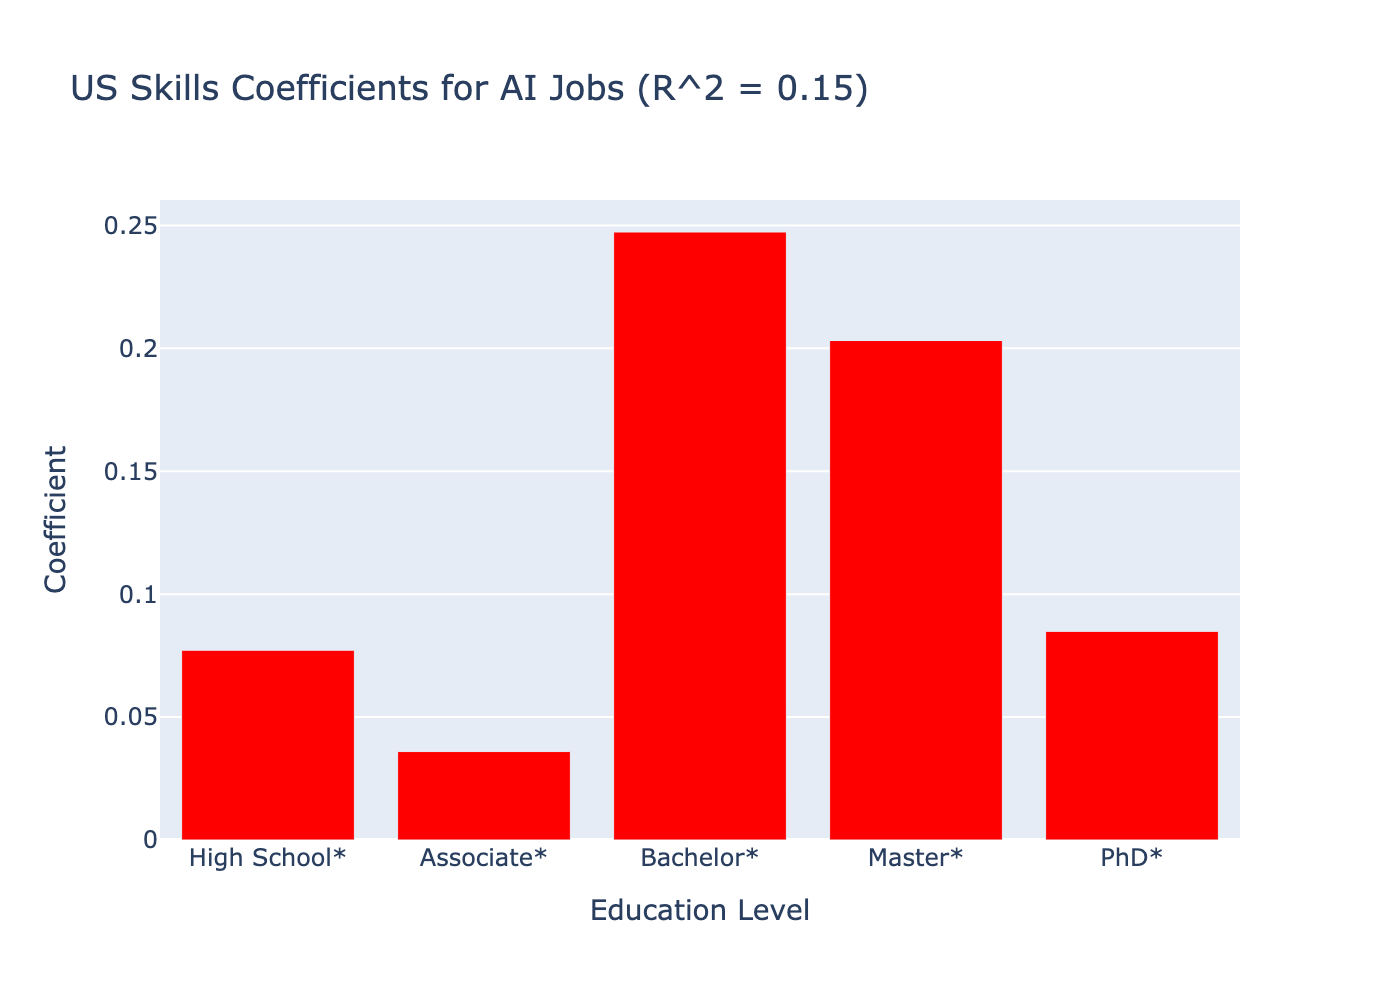

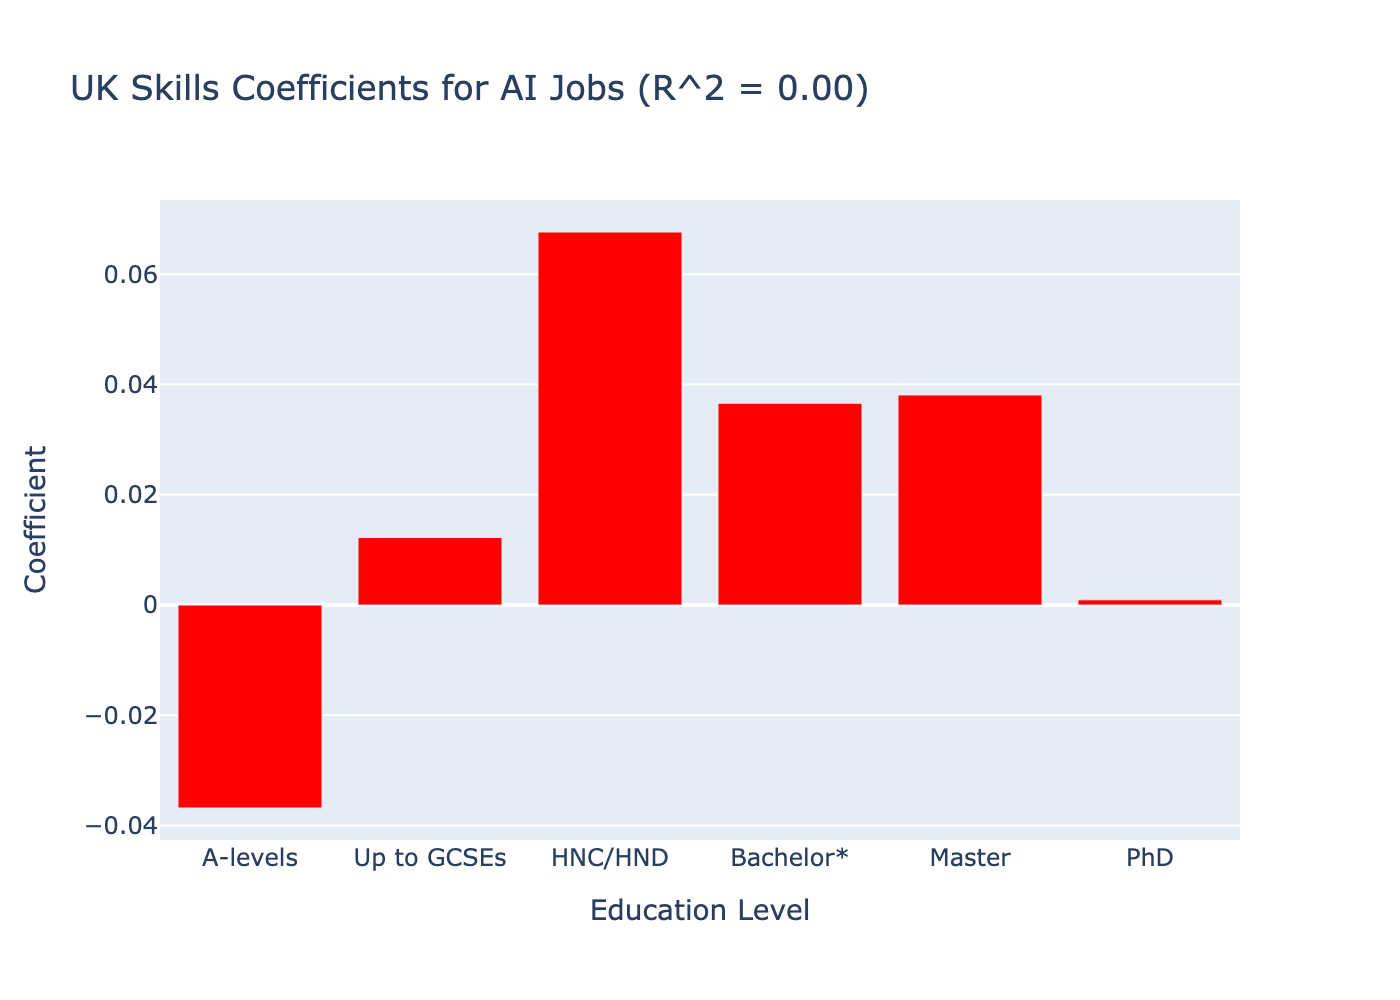

In [30]:
def display_skill_educ_coefs(df, title, r2, file_name):
    
    fig = go.Figure()
    
    for i, (education_level, coefficient, pval) in enumerate(zip(df["Education Level"], df["Coefficient"], df["P>|t|"])):
        signif = "*" if pval < 0.05 else ""
        fig.add_trace(go.Bar(
            x=[f"{education_level}{signif}"], 
            y=[coefficient], 
            name=education_level,
            marker_color="red"
        ))

    fig.update_layout(
        title=title + f" (R^2 = {r2:.2f})", 
        xaxis_title="Education Level", 
        yaxis_title="Coefficient", 
        width=700, 
        height=500,
        showlegend=False
    )

    
    with open(f"figures/{file_name}.png", "wb") as f:
        f.write(fig.to_image(format="png", engine="kaleido", scale=2))
        
    display(IPImage(filename=f"figures/{file_name}.png", width=700, height=500))
    
display_skill_educ_coefs(us_ols_coefs, "US Skills Coefficients for AI Jobs", us_r2, "us-skills-coefficients")
display_skill_educ_coefs(uk_ols_coefs, "UK Skills Coefficients for AI Jobs", uk_r2, "uk-skills-coefficients")

#### Interpretation

The goal of this regression is to see if there is a tradeoff between degrees and skills for AI jobs. The hypothesis would be that postings with higher education requirements require less skills overall. This seems to be the case for degree levels in the US where Bachelor Level AI jobs require the most skills whereas masters and PhD level jobs require less. Many of the coefficients for the UK aren't significant